In [20]:
# Import necessary libraries
import cdflib
import xarray as xr

import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

import ecef_geodetic

import sys
sys.path.append('../../SAMI3-GITM-python')
import SAMI3_ESMF_Regrid

In [2]:
fnames = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 
         'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 
         'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf'
         ]

## Read in data

In [3]:
# Same as old Prasoon code - maybe could be changed? Works fine though
# Modification marked below:

grace = [] # list of Xarray DataSets from each day

for f in tqdm(fnames): # Probably don't need a progress bar here. only takes ~15 seconds
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = pd.Timestamp(f.split('_')[-2])  # Aaron changed how date_0 was calculated.
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})
    lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
    data['LT'] = ('step', lt, {'step':step})
    
    grace.append(data)

print('Columns in Satellite Data: \n', data.data_vars, 
      'Start & end dates:', data.date.min().values, data.date.max().values)

100%|█████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]


Columns in Satellite Data: 
 Data variables:
    Timestamp          (step) float64 438kB 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 438kB -59.12 -59.12 -59.77 ... 24.74 24.74
    Longitude          (step) float64 438kB -175.2 -175.2 -175.2 ... 2.673 2.673
    Radius             (step) float64 438kB 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 438kB 1.975e+06 -3.314e+06 ... 2.534e+07
    GPS_Position_Y     (step) float64 438kB -1.886e+07 -2.172e+07 ... -7.897e+06
    GPS_Position_Z     (step) float64 438kB -1.894e+07 -1.513e+07 ... 3.192e+06
    LEO_Position_X     (step) float64 438kB -3.49e+06 -3.49e+06 ... 6.189e+06
    LEO_Position_Y     (step) float64 438kB -2.959e+05 -2.959e+05 ... 2.89e+05
    LEO_Position_Z     (step) float64 438kB -5.858e+06 -5.858e+06 ... 2.855e+06
    PRN                (step) uint16 109kB 11 32 11 32 11 32 ... 21 25 29 30 31
    L1                 (step) float64 438kB 2.347e+07 2.351e+07 ... 2.074e+07
  

In [4]:
# Data is flat - convert it to a Pandas DataFrame. 
# They're easier to work with and writing csv files is built-in.

# Concat the list of xr Datasets, converting each to Pandas as we go
df0 = pd.concat([i.to_pandas() for i in grace]).sort_values('date')

# Only select columns I care about - drop the index too 
df = df0[['Timestamp', 'GPS_Position_X', 
       'GPS_Position_Y', 'GPS_Position_Z', 'LEO_Position_X', 'LEO_Position_Y',
       'LEO_Position_Z', 'PRN', 'Latitude', 'Longitude',
       'Absolute_STEC', 'Elevation_Angle', 'date', 'LT']].reset_index(drop=True)

## Mask off data we don't want

This should be easy to change if other data is required

The variable `df` is kept so the code after selecting data is generalizable. 

There is some debug info printed & plotted. None of that is necessary... I'm leaving it in for proofthat the code is working as expected. The cells can be deleted. I would have but wanted to show Prasoon what's happening

In [5]:
# Only keep data on the 17th

# Probably needs to also include a condition on elevation angle...

In [6]:
df = df.iloc[np.where((df.date > pd.Timestamp('20130317'))
                    & (df.date < pd.Timestamp('20130318')))].reset_index(drop=True)

In [7]:
# Just check to make sure things look right - can delete this cell. not needed
df.columns, df.PRN.unique(), df.date.min(), df.date.max()

(Index(['Timestamp', 'GPS_Position_X', 'GPS_Position_Y', 'GPS_Position_Z',
        'LEO_Position_X', 'LEO_Position_Y', 'LEO_Position_Z', 'PRN', 'Latitude',
        'Longitude', 'Absolute_STEC', 'Elevation_Angle', 'date', 'LT'],
       dtype='object'),
 array([11, 12, 14, 18, 25, 31, 21, 30,  6, 16, 29,  3,  5, 13,  7, 10, 26,
         2,  8,  4,  9, 28, 17, 20, 32, 22, 19, 15, 23], dtype=uint16),
 Timestamp('2013-03-17 00:00:09'),
 Timestamp('2013-03-17 23:59:59'))

### Select one orbit

Since this is just me debgging, I'm going to filter by day AND only take one of those orbits. 

In [8]:
# Find where absolute value of df.Latitude is highest
# Returns peaks & their values. don't care about values, store it as a `_` and forget about it.
peaks, _ = find_peaks(df.Latitude.abs())
print(len(peaks))

30


In [9]:
# Function for rays along Line of sight from Grace to GPS satellite

def line_of_sight_calc(start, end, #start and end pts
                       num_points=50, # number of points 
                       base = 4, # Adjust base of log to get required point density
                       spacing='log'): # currently supports log & linear
    # Calculate direction vector
    direction = np.array(end) - np.array(start)
    
    if spacing == 'log':
        # see below for a discussion on why I did this
        deltas = np.geomspace(0.00001, 1, num=num_points) ** (base/10)
    
    elif spacing == 'linear':
        deltas = np.linspace(0, 1, num=num_points)
        
    else:
        raise ValueError
    
    # Scale and translate values to fit the line segment
    points = [start + t * direction for t in deltas]

    return points

In [ ]:
orbits =  list(range(13))

for orbit_num in tqdm(orbits):
    # Storing indices for given orbit
    peaks, _ = find_peaks(df.Latitude.abs())
    peaks = peaks[orbit_num:orbit_num+2]

    df1 = df.iloc[peaks[0]:peaks[1]].reset_index(drop=True)

    # Generating cartesian points along the ray of Line of sight
    cartesian_points = []
        
    for _, row in df1.iterrows(): # Returns index, row... don't care about index
        
        grace_cart_loc = [row['LEO_Position_X'],
                          row['LEO_Position_Y'],
                          row['LEO_Position_Z']]
    
        gps_cart_loc = [row['GPS_Position_X'],
                        row['GPS_Position_Y'],
                        row['GPS_Position_Z']]
        
        # Compute ray - this is a (N_points, 3) shaped array
        a_ray = line_of_sight_calc(grace_cart_loc, gps_cart_loc)
        
        # Convert back to lat/lon/alt - ecef conversions need x,y,z & can't be vectorized
        a_ray_sph = [] # Same shape as a_ray
        for pt in a_ray:
            a_ray_sph.append(ecef_geodetic.ecef_to_lla(*pt))
            
        cartesian_points.append(a_ray_sph)
    
    cartesian_points = np.array(cartesian_points) # easier to slice from than list

    # Converting output to dataframe
    df_raypaths = pd.DataFrame()
    df_raypaths['lat'] = cartesian_points[:,:,0].flatten()
    df_raypaths['lon'] = cartesian_points[:,:,1].flatten()
    df_raypaths['alt'] = cartesian_points[:,:,2].flatten() / 1000

    path = '/home/pxv220016/scratch/'
    csv_name = path + 'multiorbit_data/single_orbit_los_' + str(orbit_num) + '.csv'
    csv_raw_name = path + 'multiorbit_data/single_orbit_raw_' + str(orbit_num) + '.csv'
    df_raypaths.to_csv(csv_name, index=False)
    df1.to_csv(csv_raw_name, index=False)

    file_name = path + 'multiorbit_data/orbit_' + str(orbit_num)
    
    SAMI3_ESMF_Regrid.main(sami_data_path='/home/pxv220016/scratch/2013-03-17_SAMI', 
                           dtime_sim_start='20130316',
                           cols='edens',
                           out_dir='/home/pxv220016/scratch/multiorbit_data',
                           custom_input_file=csv_name,
                           ESMF_DIR='/home/pxv220016/prasoon/data/SAMI3-GITM-python/esmf-8.4.0/apps/appsO/Linux.gfortran.64.openmpi.default/',
                           remake_files=True,
                           output_filename=file_name,
                             )
    
    print('DONE...', orbit_num)
    
    

# Orbit Analysis

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter, butter, sosfiltfilt, sosfilt_zi, sosfilt, lfilter, filtfilt

from tqdm import tqdm
import importlib as il
import ecef_geodetic
import datetime as dt

In [3]:
def filt_filt(da,
              freq=5,
              lims=[40, 85],
              order=1,
              percent=True):

    # Define sampling frequency and limits in minutes
    sampling_freq = freq
    lower_limit = min(lims)
    upper_limit = max(lims)

    # Convert limits to corresponding indices
    lower_index = int(lower_limit / sampling_freq)
    upper_index = int(upper_limit / sampling_freq)

    # Design the bandpass filter
    nyquist_freq = 0.5 * sampling_freq
    lower_cutoff = lower_index / nyquist_freq
    upper_cutoff = upper_index / nyquist_freq
    b, a = butter(order, [1/upper_cutoff, 1/lower_cutoff],
                  btype='band', analog=False)

    # Apply the filter to the data
    filtd = filtfilt(b, a, da, axis=1)
    # filtd = xr.apply_ufunc(filtfilt, b, a, da, dask='allowed')

    if percent:
        return (100*(filtd)/da)

    else:
        da.values = filtd
        return da

  0%|                                                    | 0/12 [00:00<?, ?it/s]

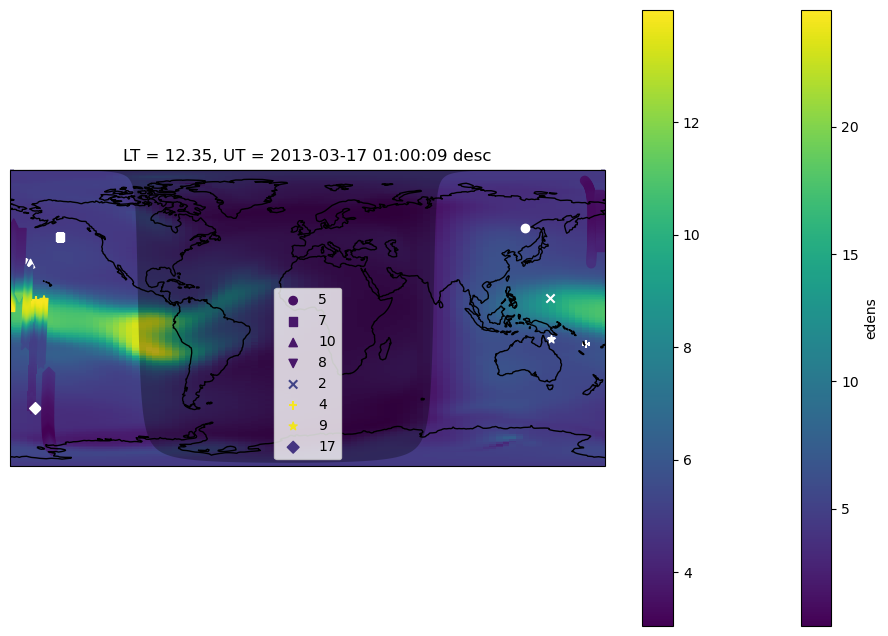

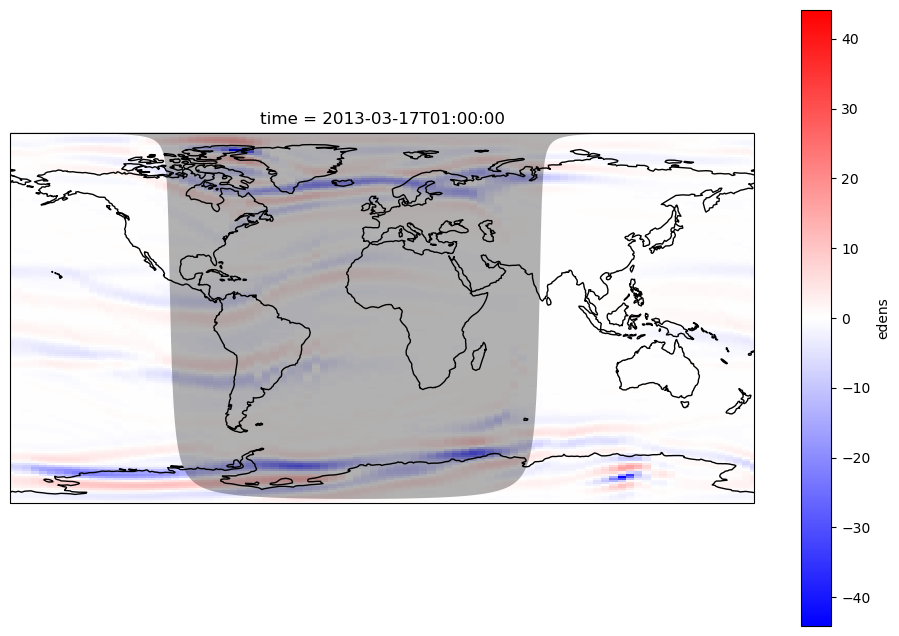

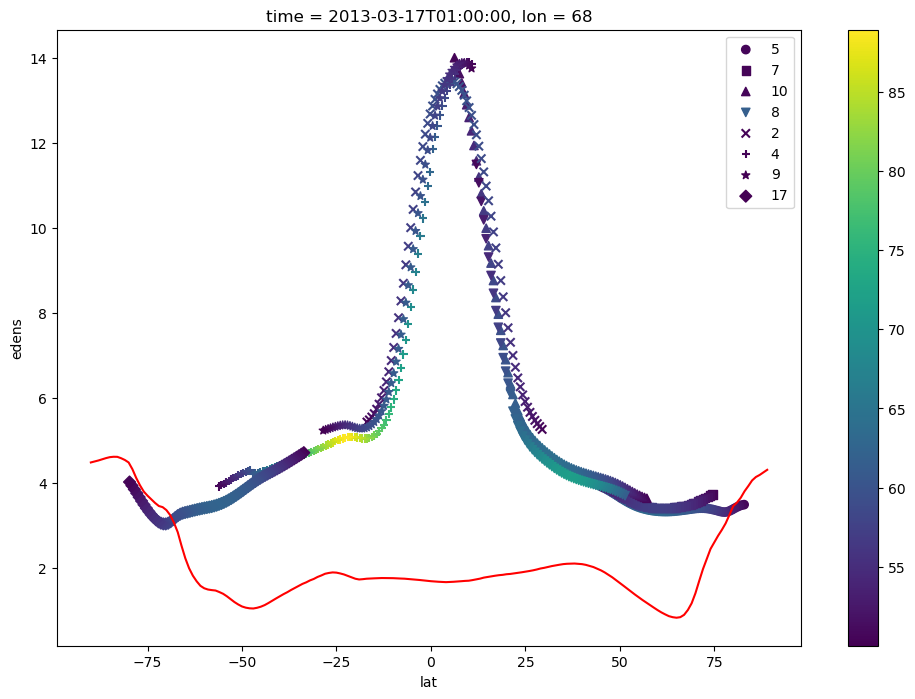

584 254
254


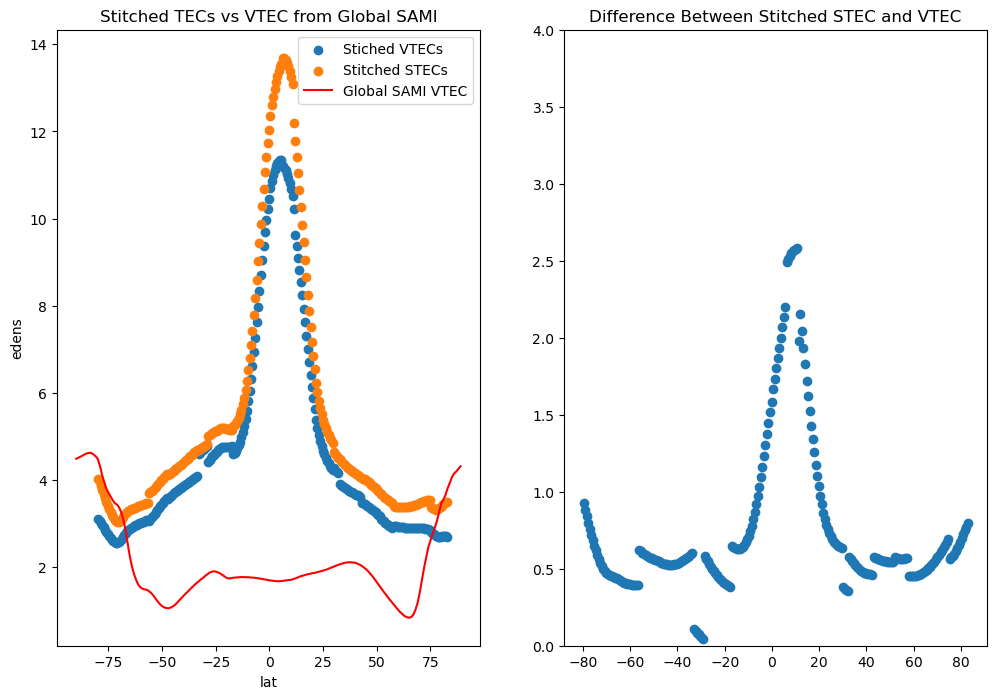

  8%|███▋                                        | 1/12 [00:15<02:54, 15.86s/it]

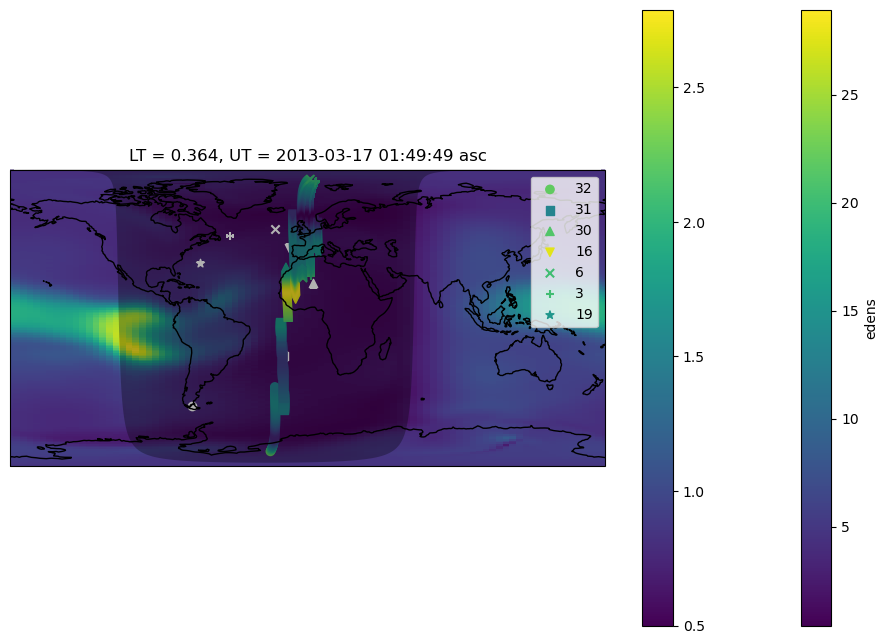

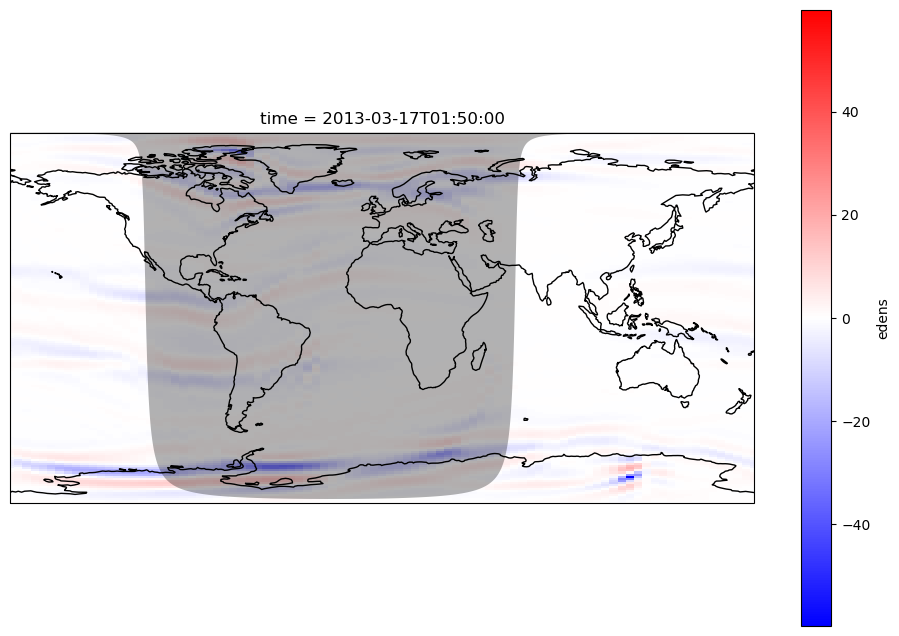

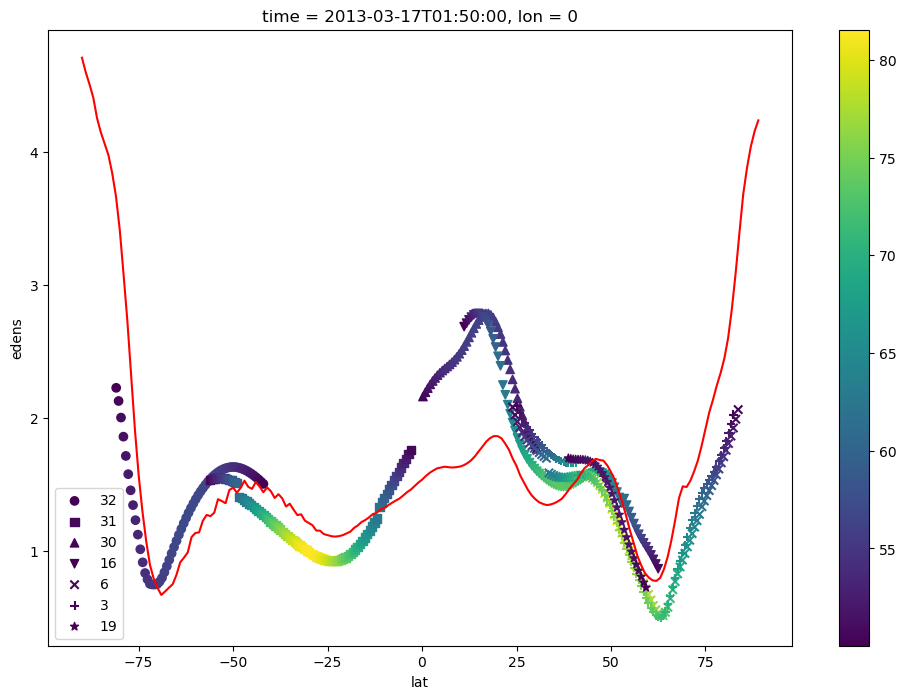

492 254
254


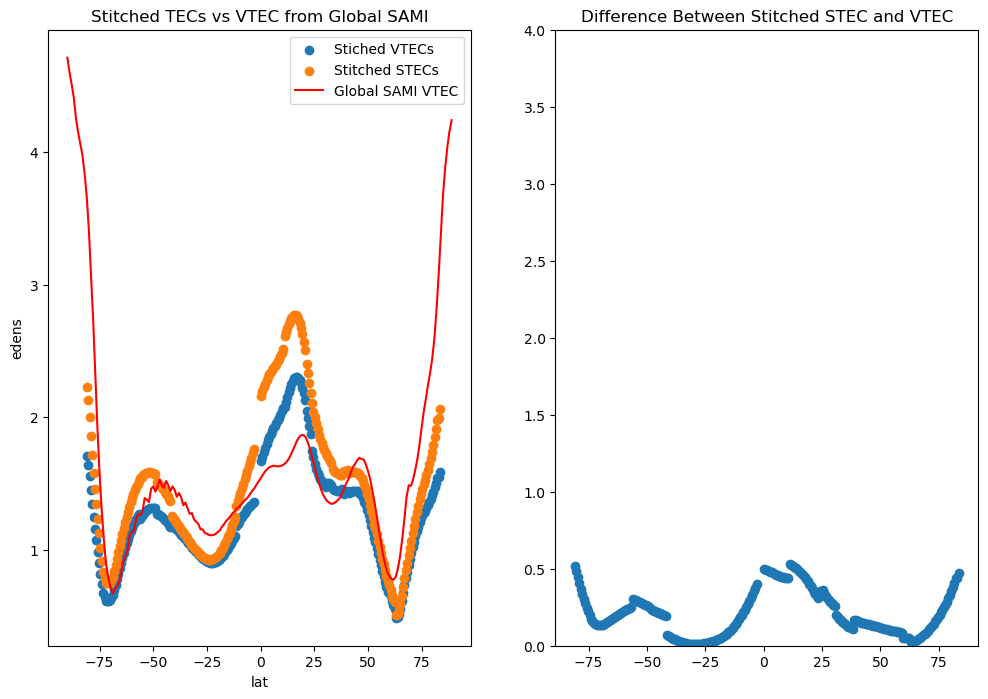

 17%|███████▎                                    | 2/12 [00:32<02:45, 16.52s/it]

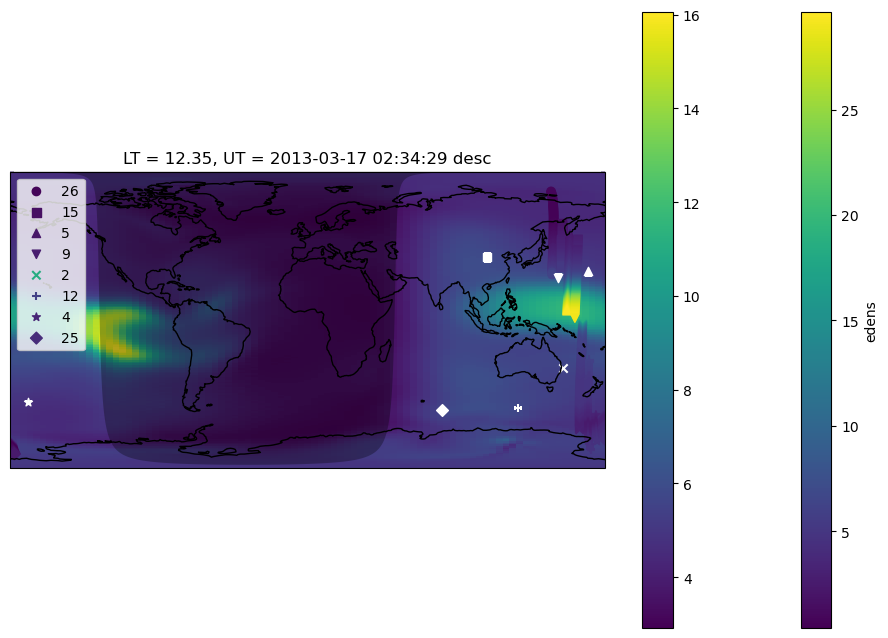

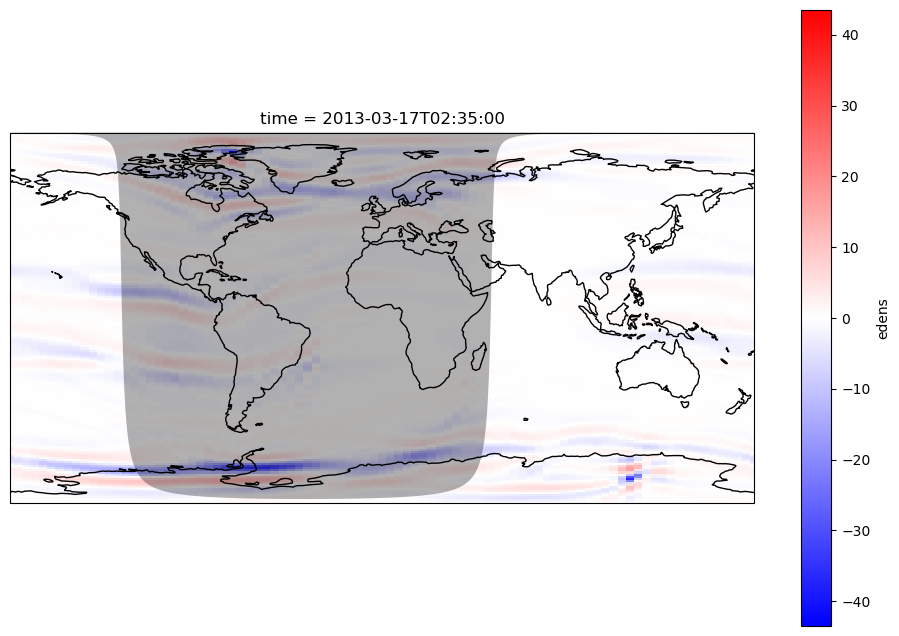

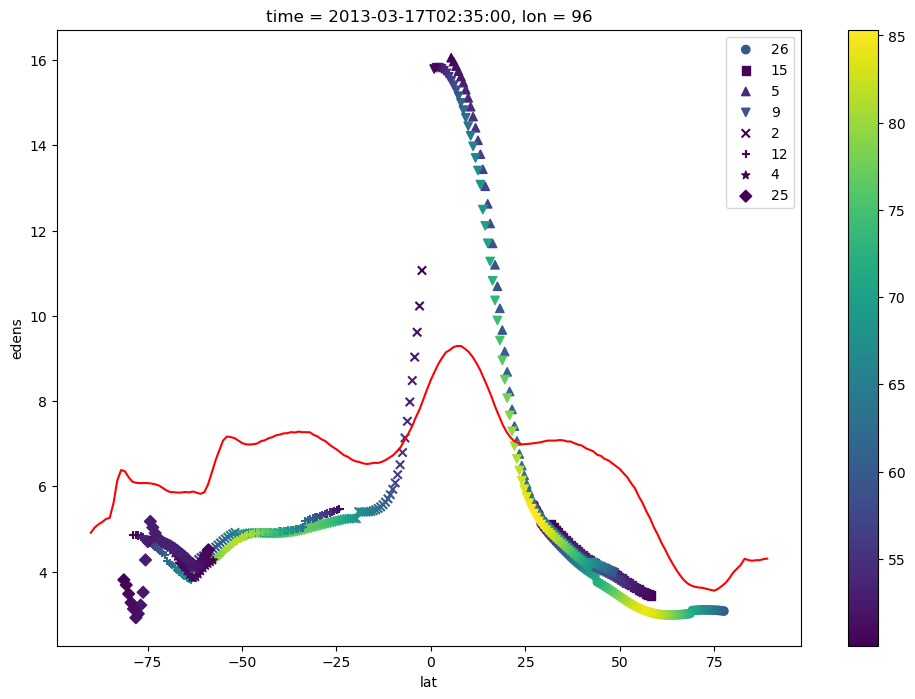

517 244
244


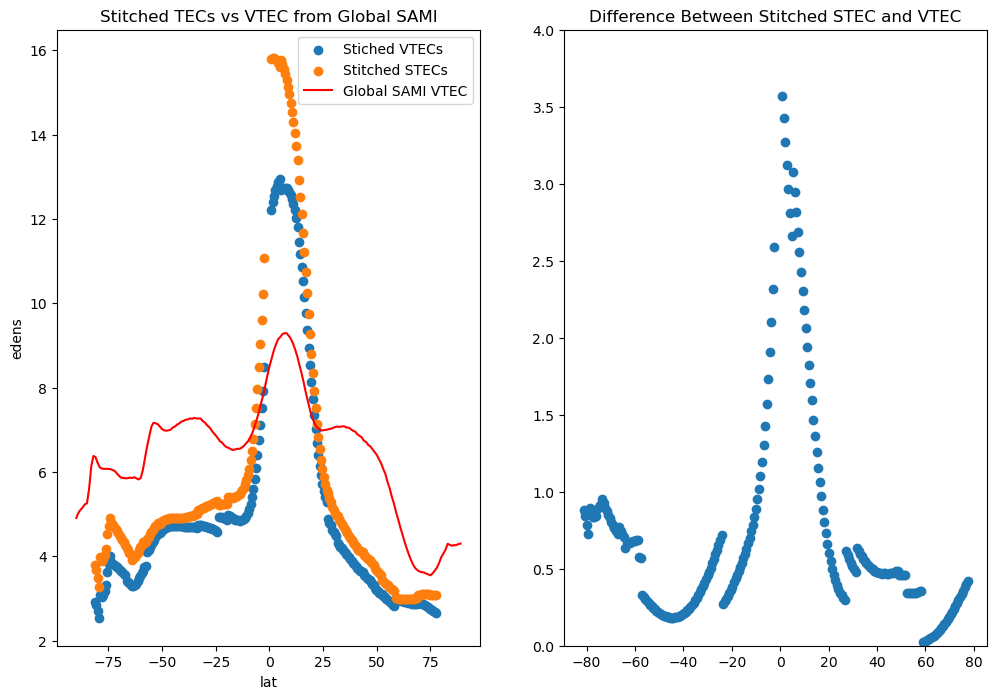

 25%|███████████                                 | 3/12 [00:48<02:24, 16.11s/it]

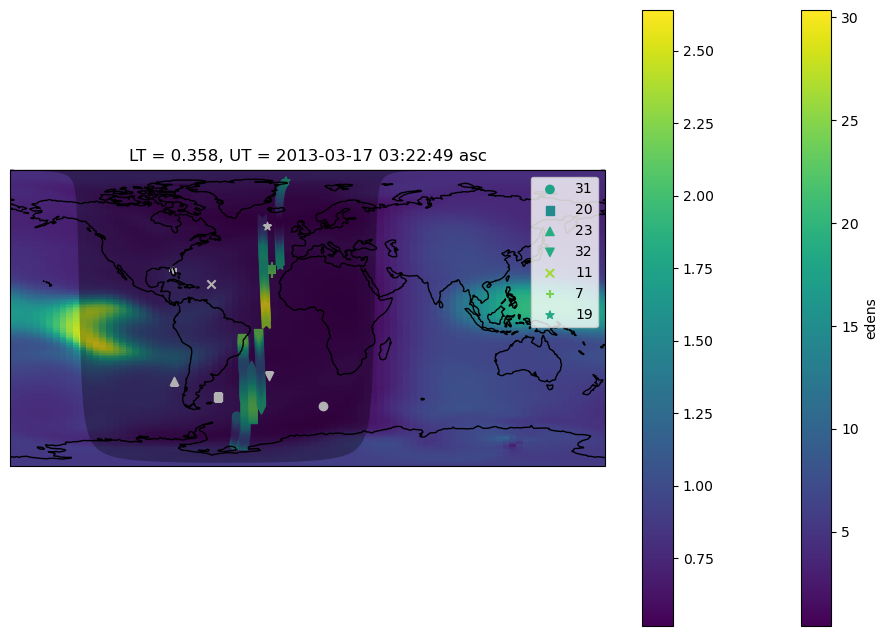

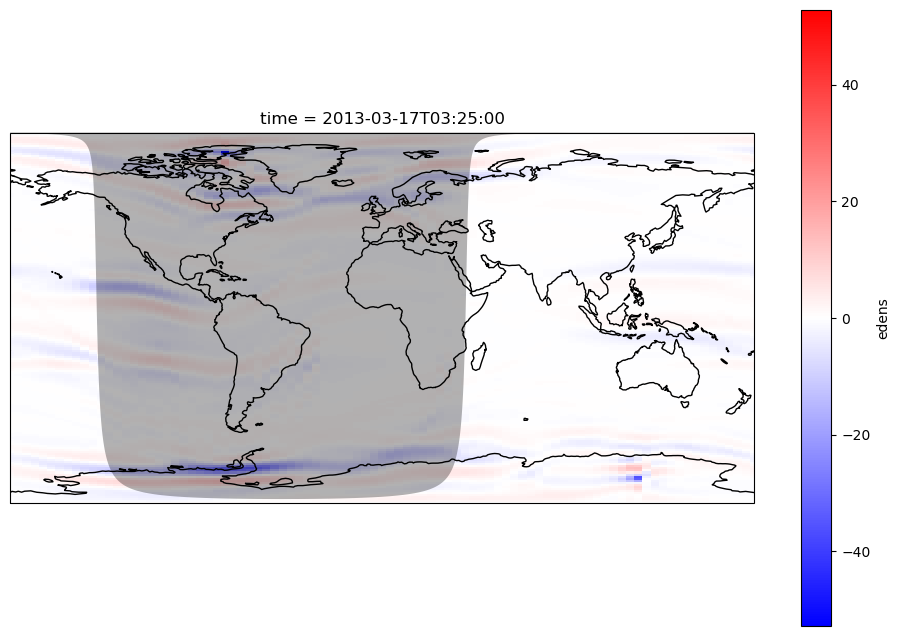

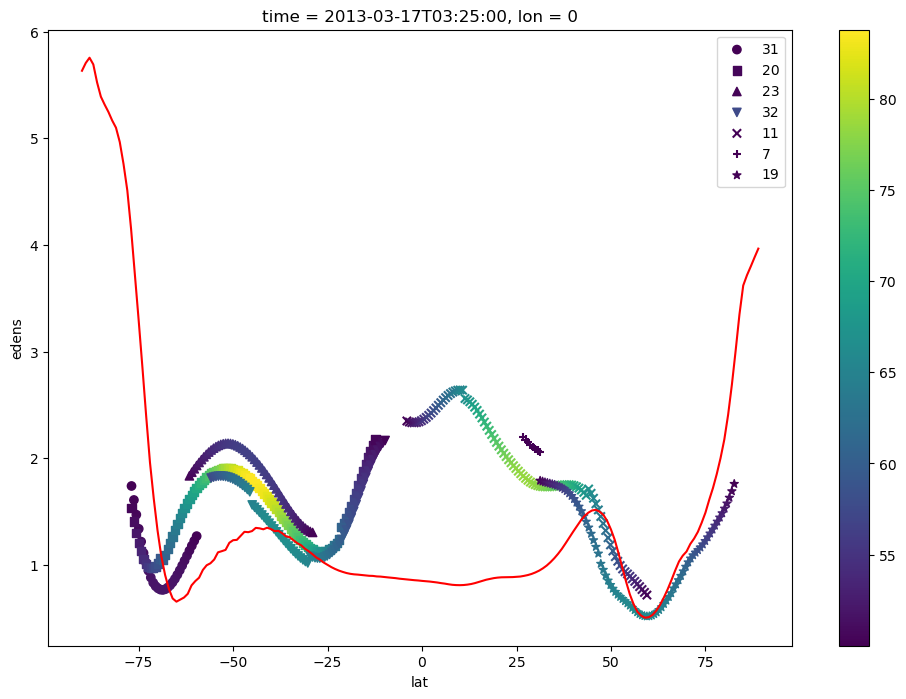

444 242
242


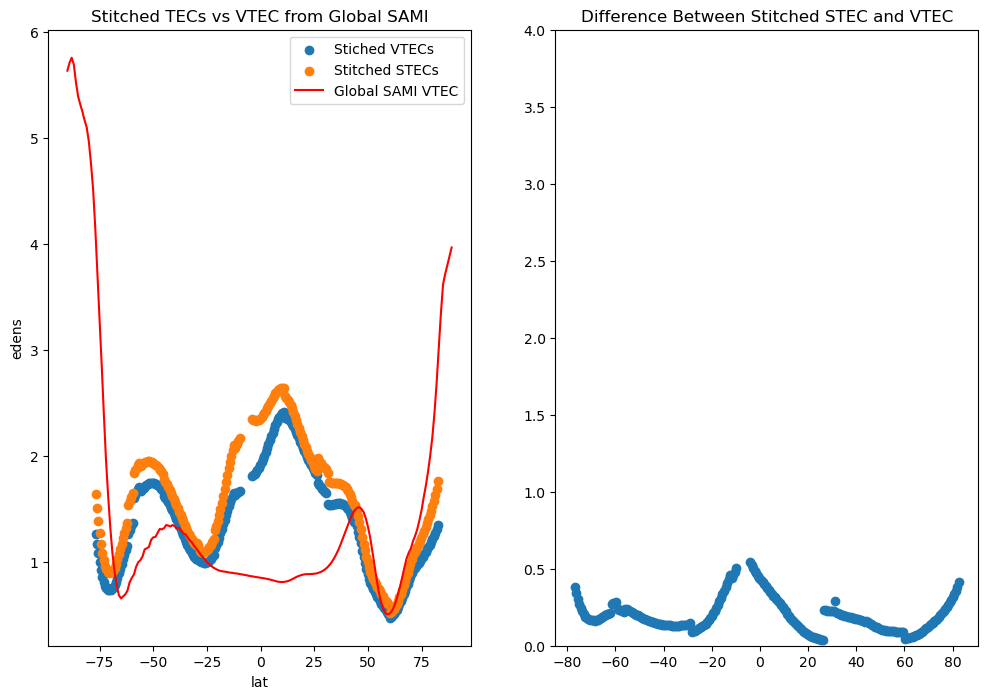

 33%|██████████████▋                             | 4/12 [01:05<02:11, 16.43s/it]

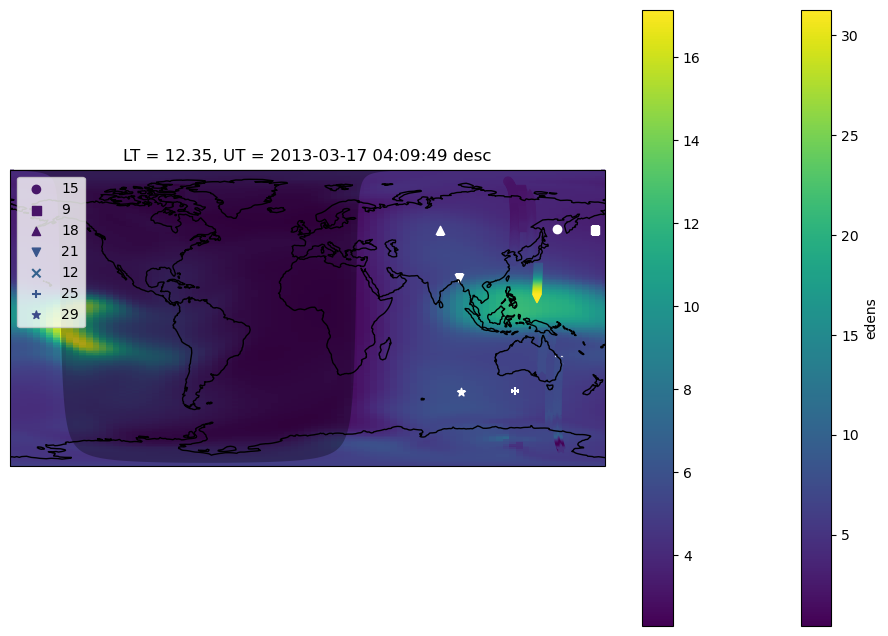

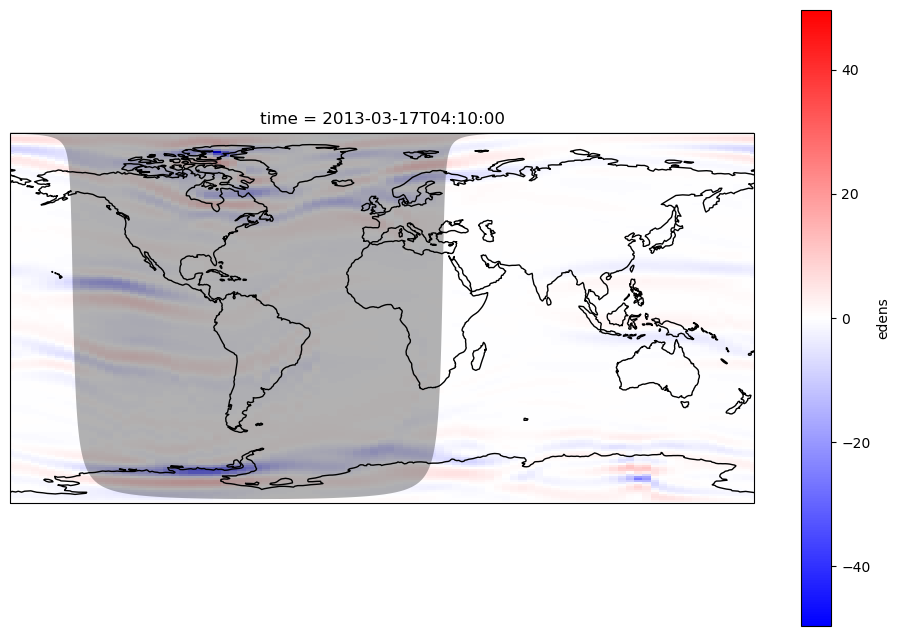

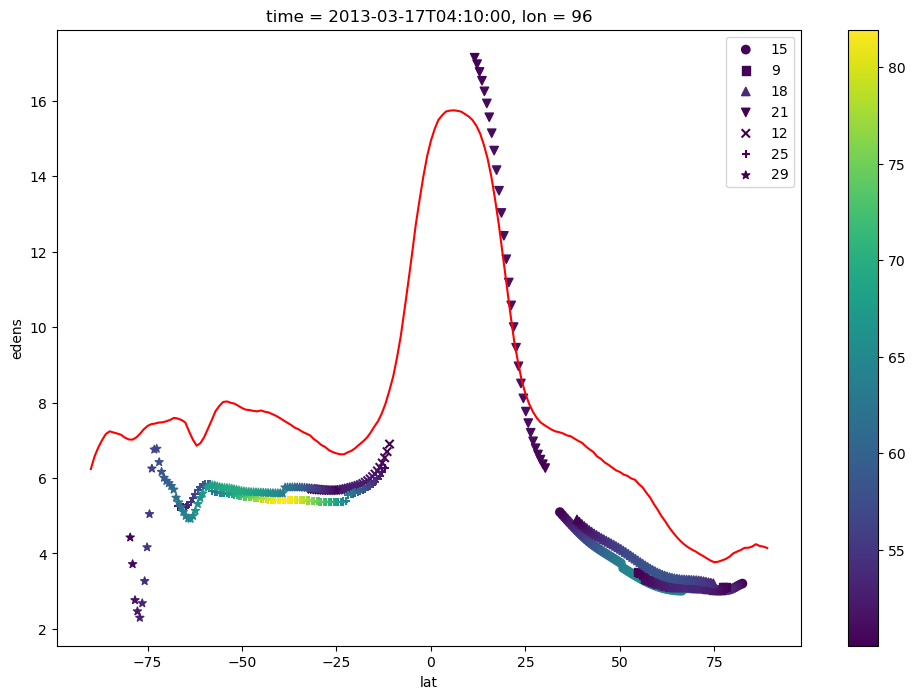

404 214
214


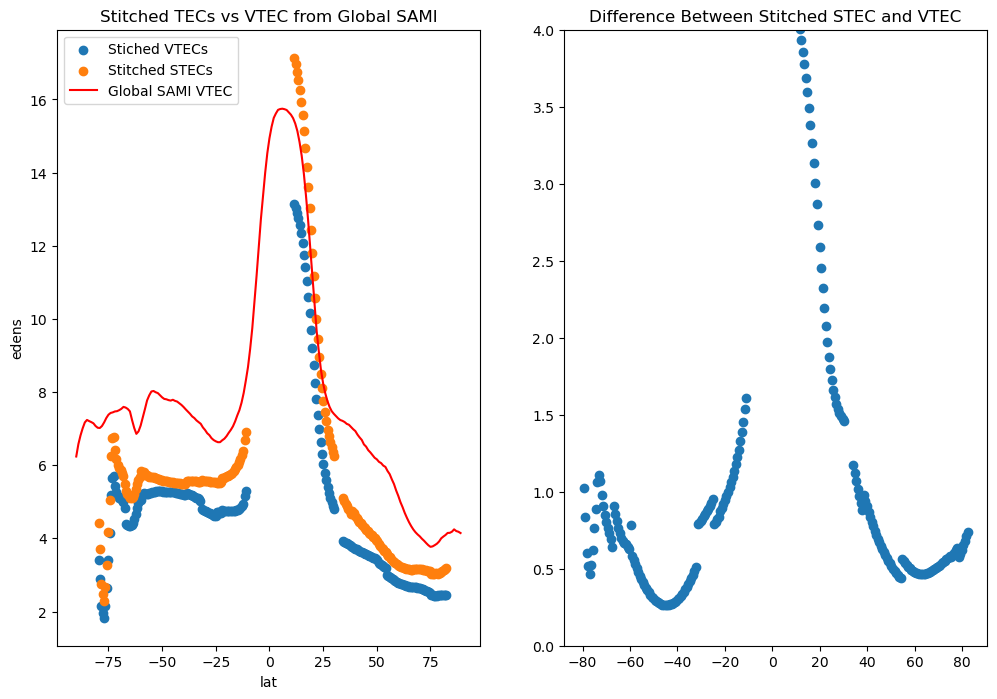

 42%|██████████████████▎                         | 5/12 [01:21<01:54, 16.37s/it]

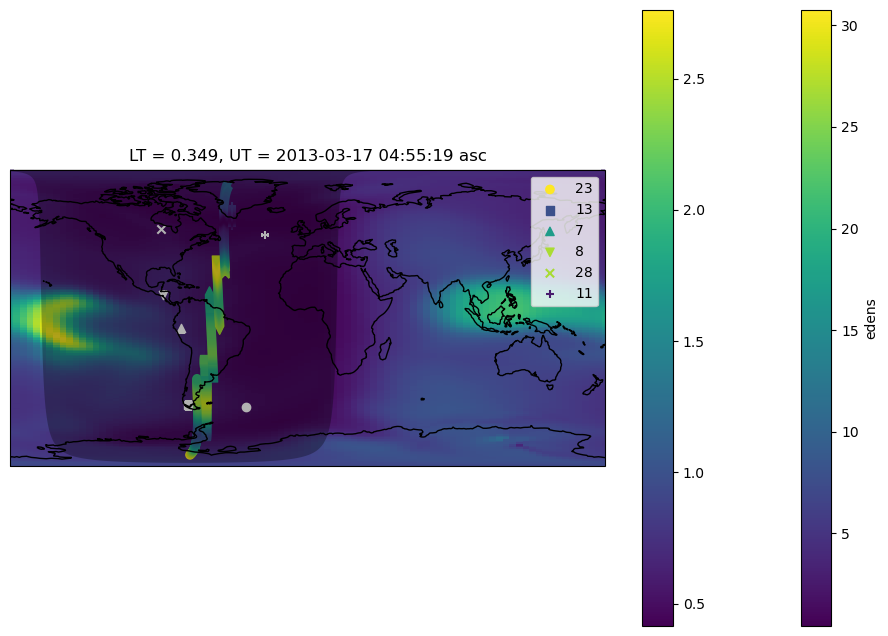

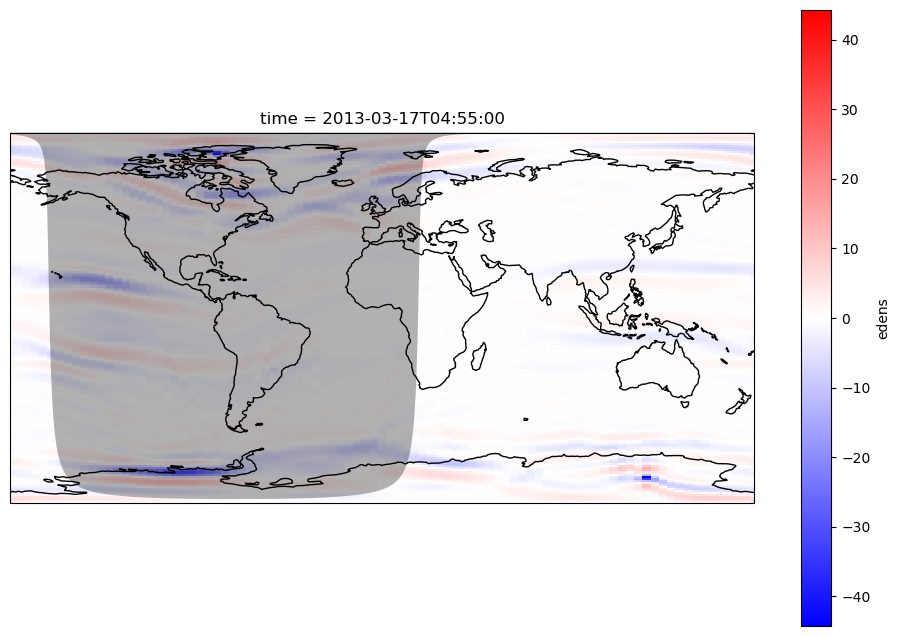

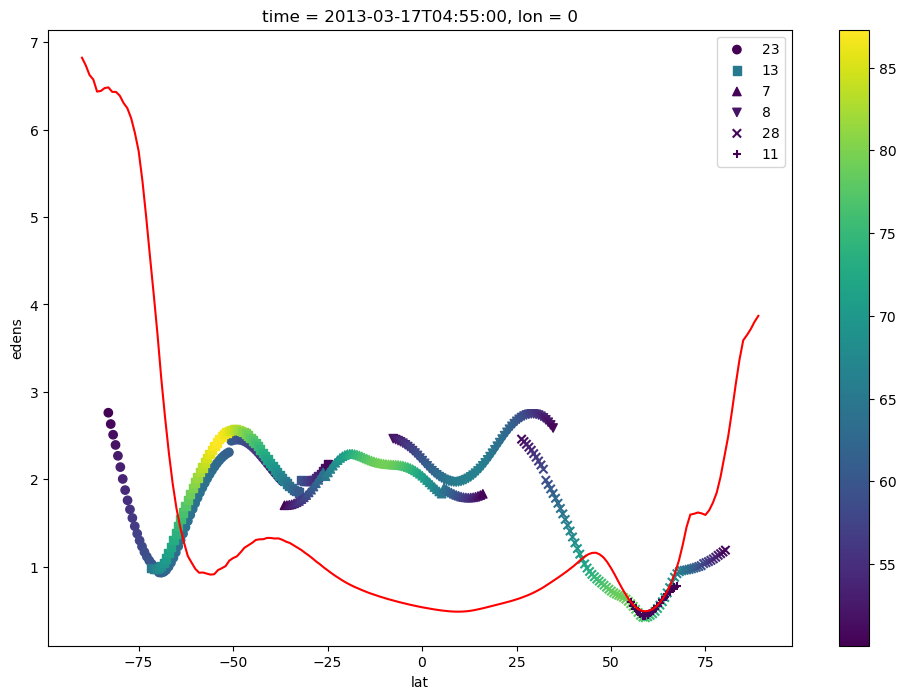

402 256
256


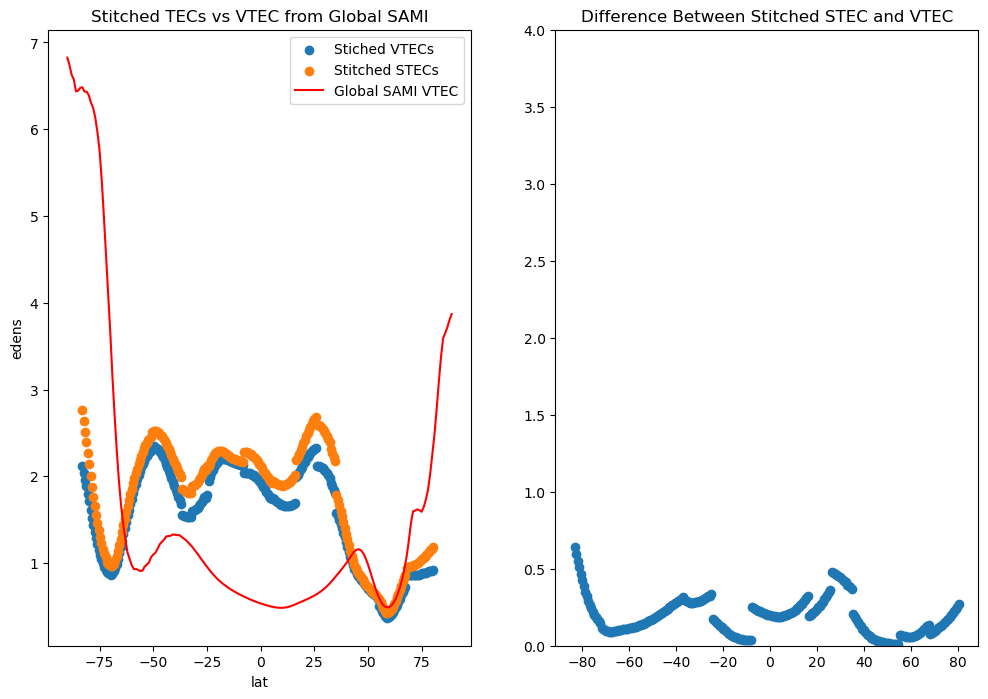

 50%|██████████████████████                      | 6/12 [01:38<01:38, 16.43s/it]

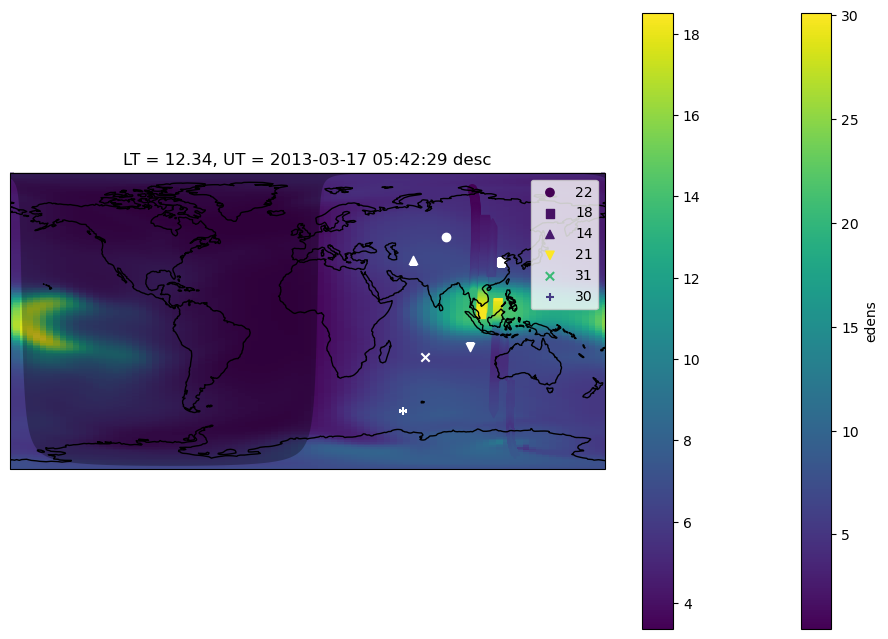

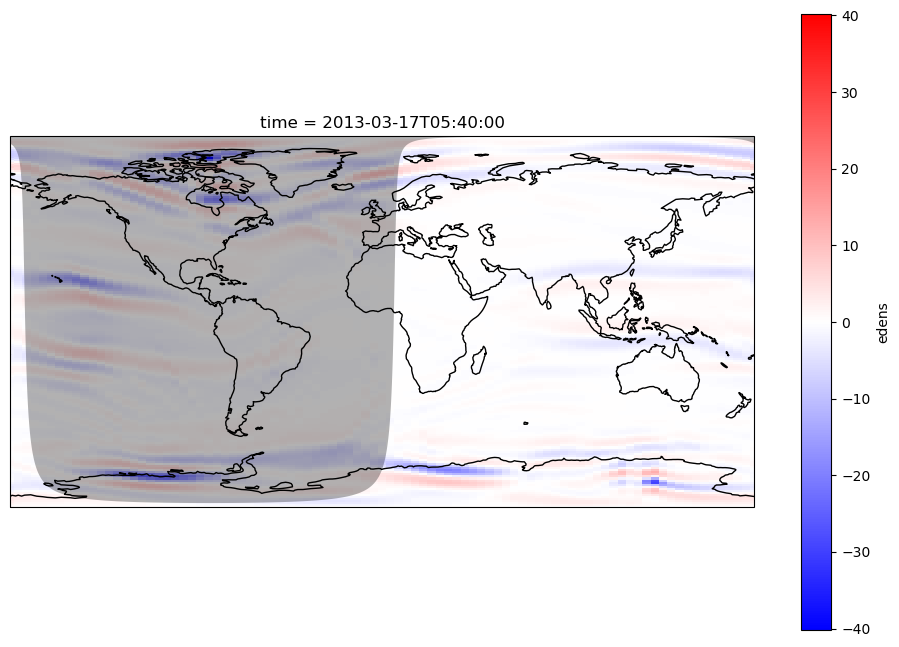

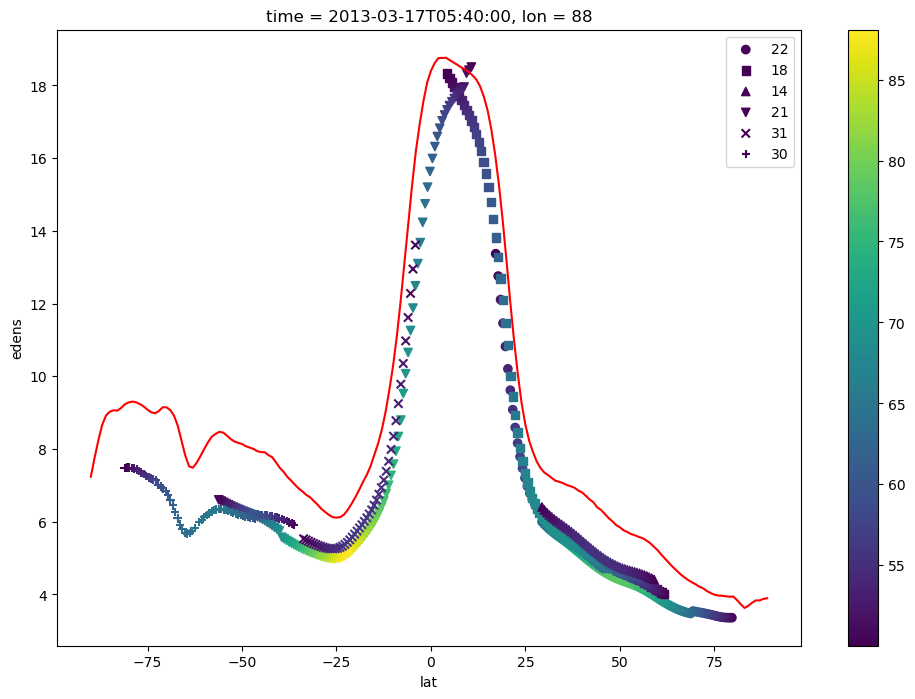

457 250
250


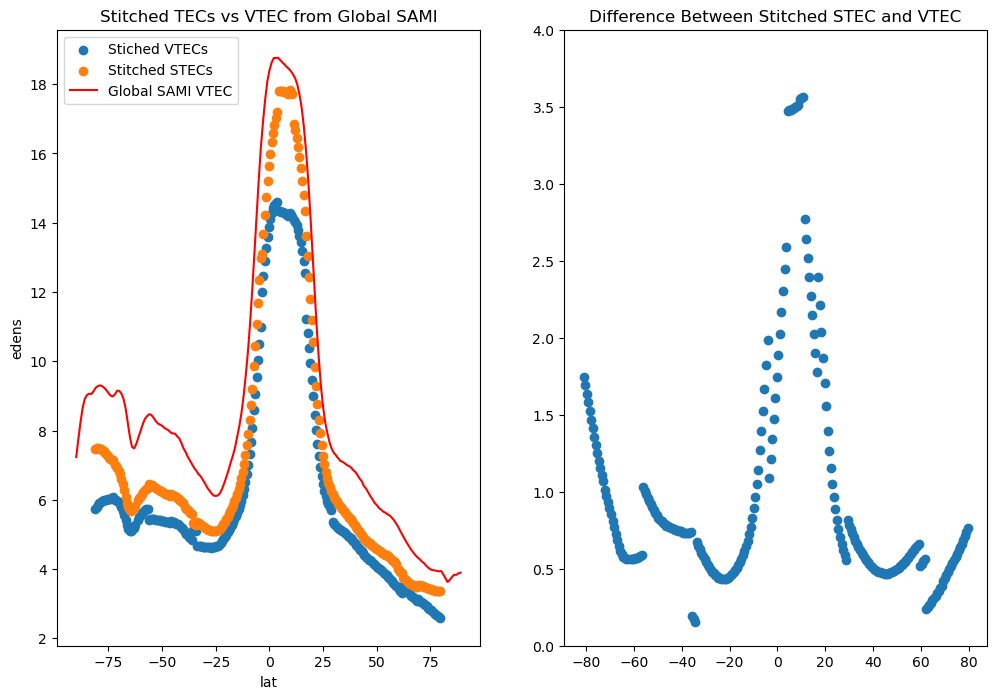

 58%|█████████████████████████▋                  | 7/12 [01:54<01:21, 16.23s/it]

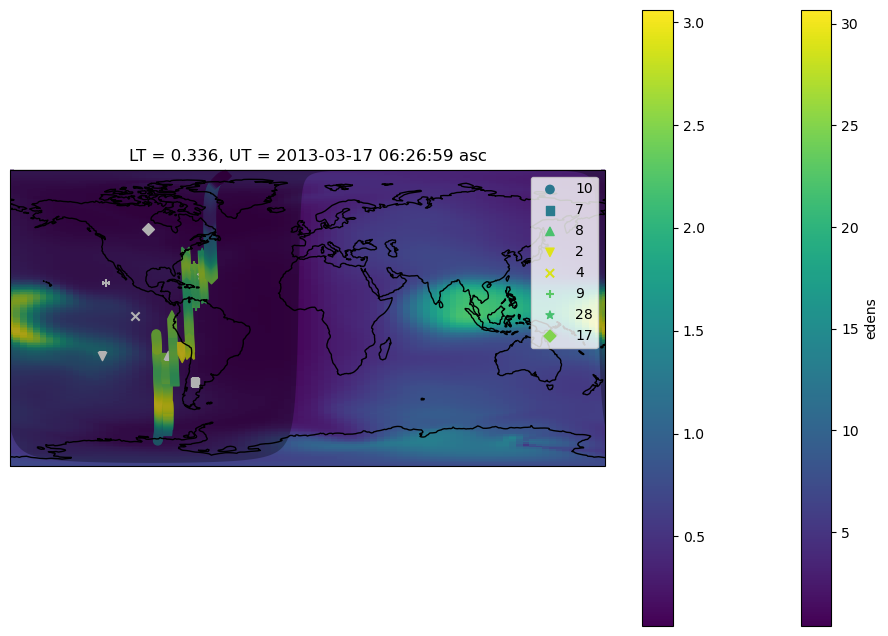

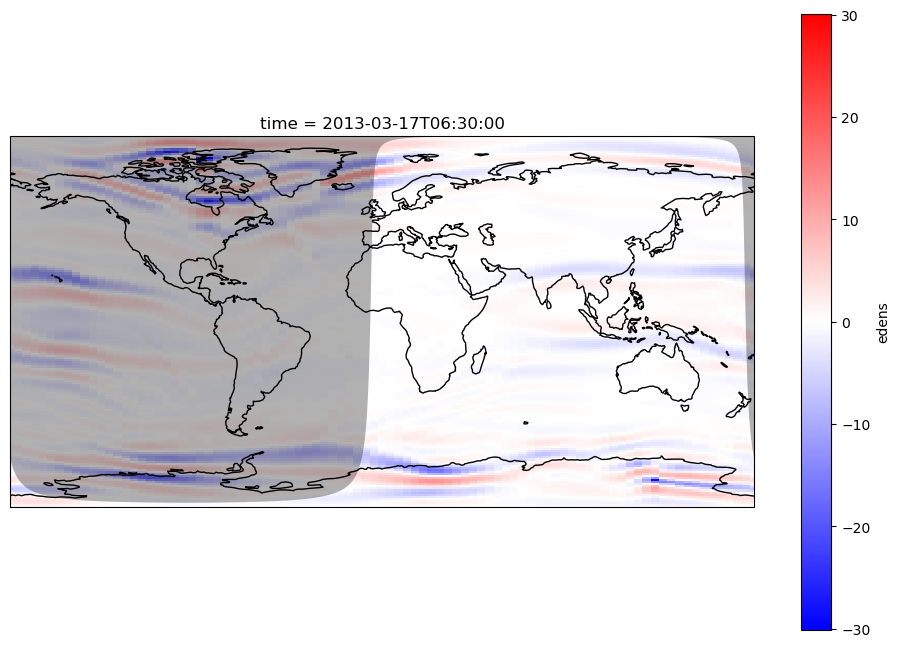

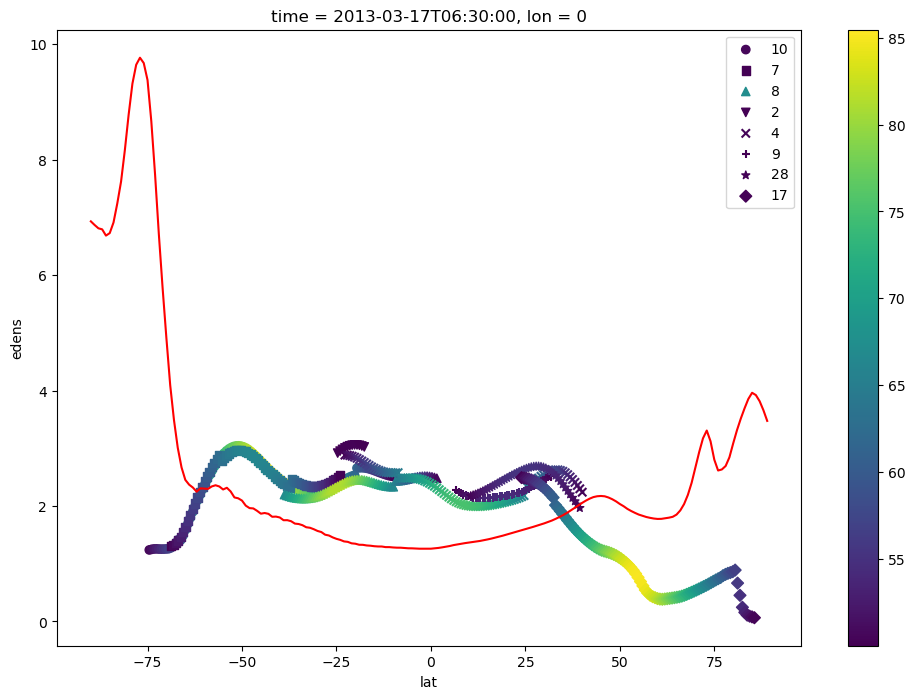

531 251
251


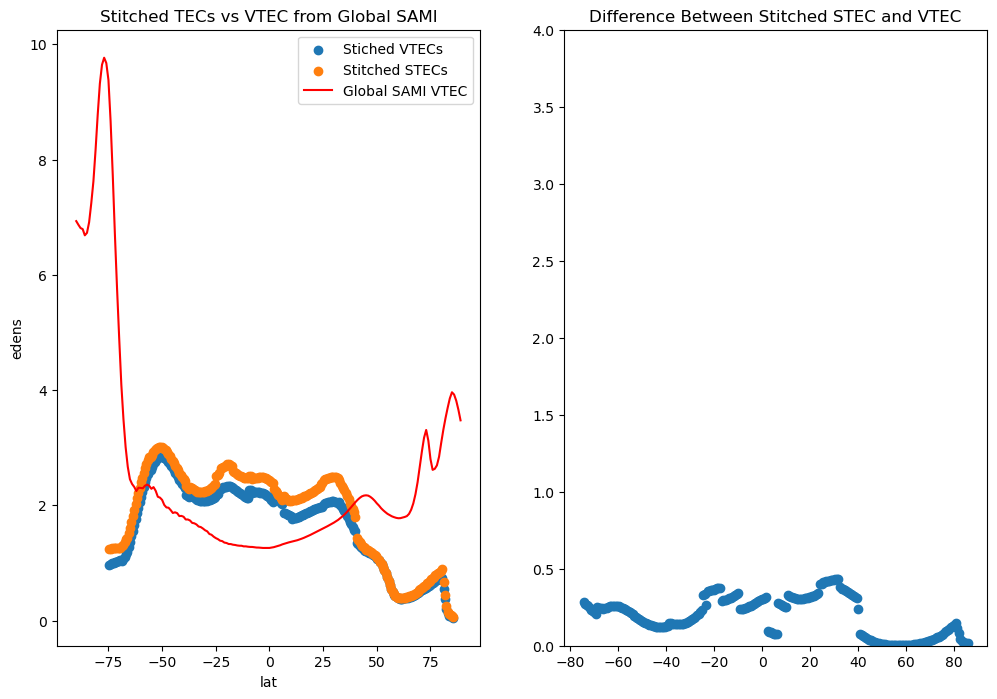

 67%|█████████████████████████████▎              | 8/12 [02:10<01:04, 16.19s/it]

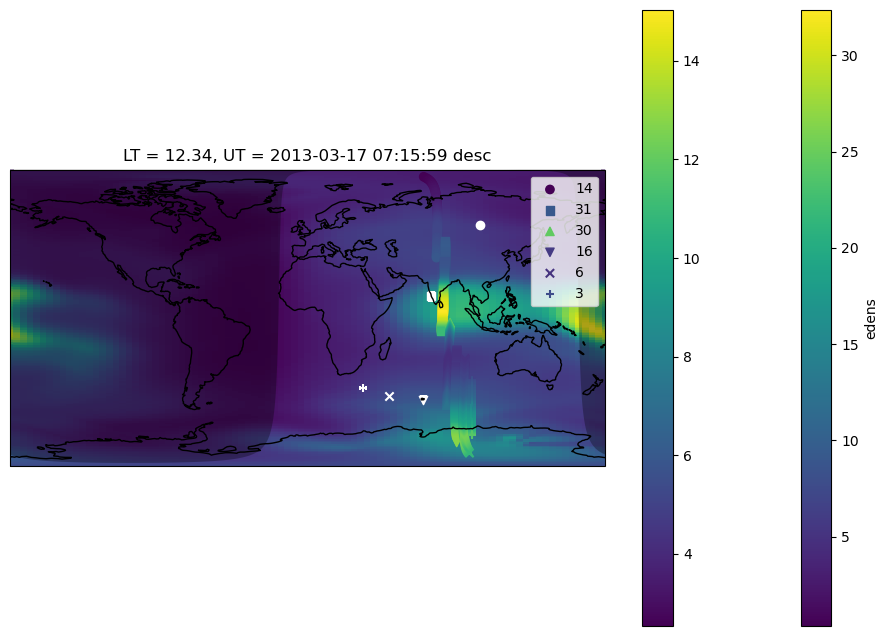

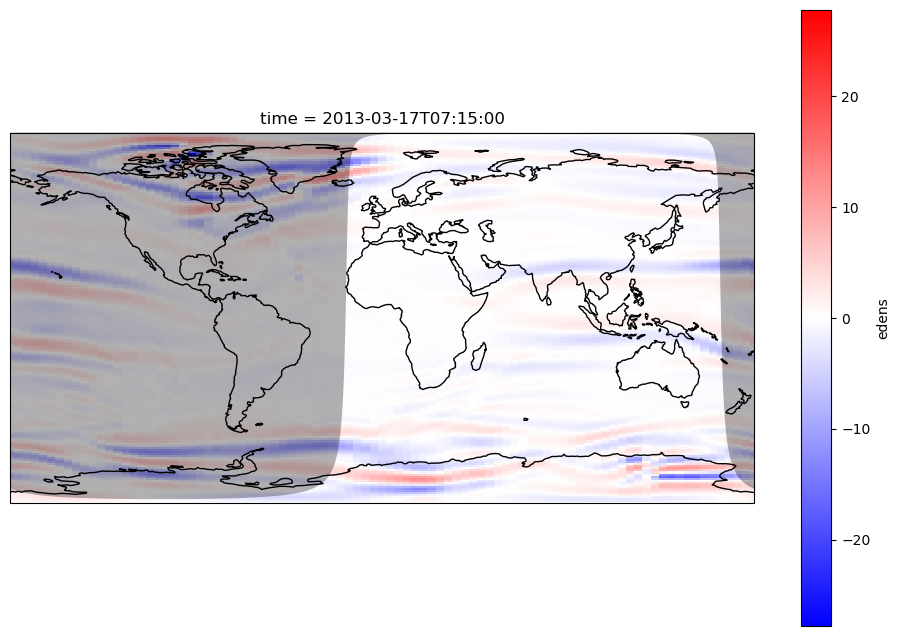

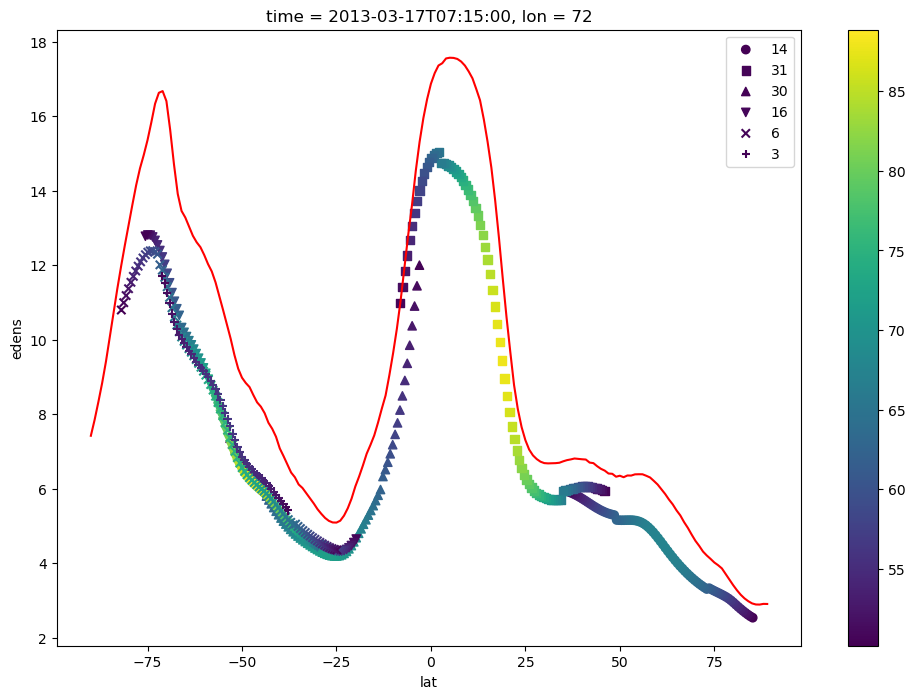

472 261
261


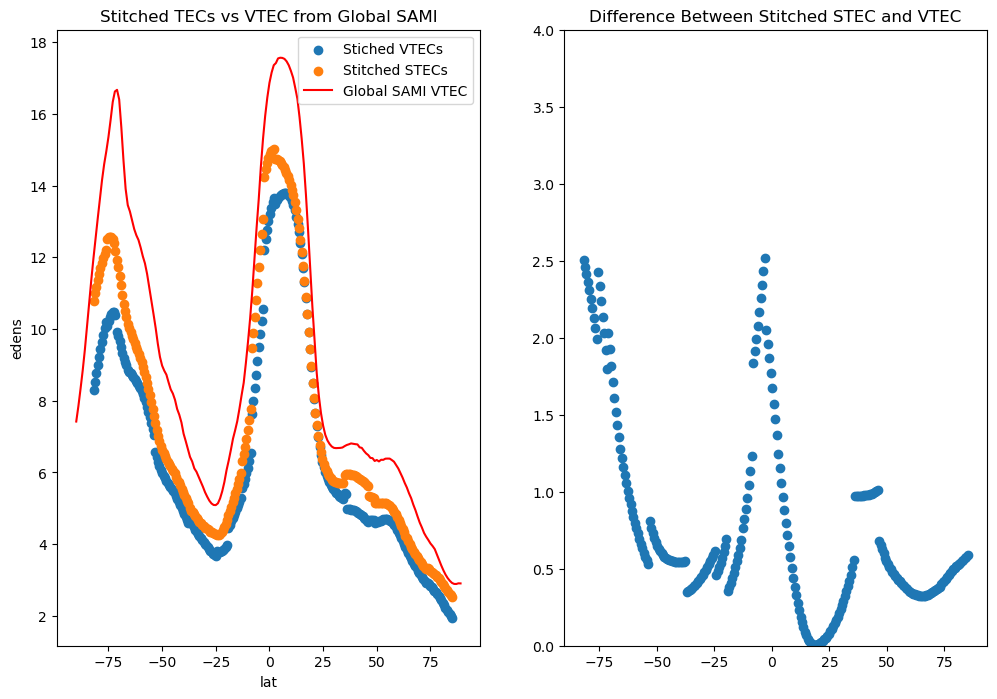

 75%|█████████████████████████████████           | 9/12 [02:26<00:48, 16.33s/it]

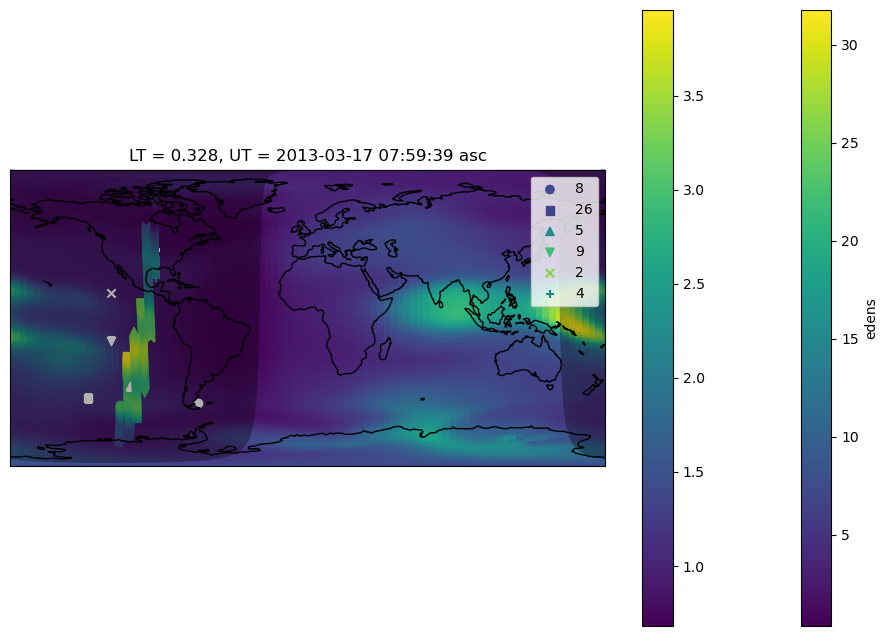

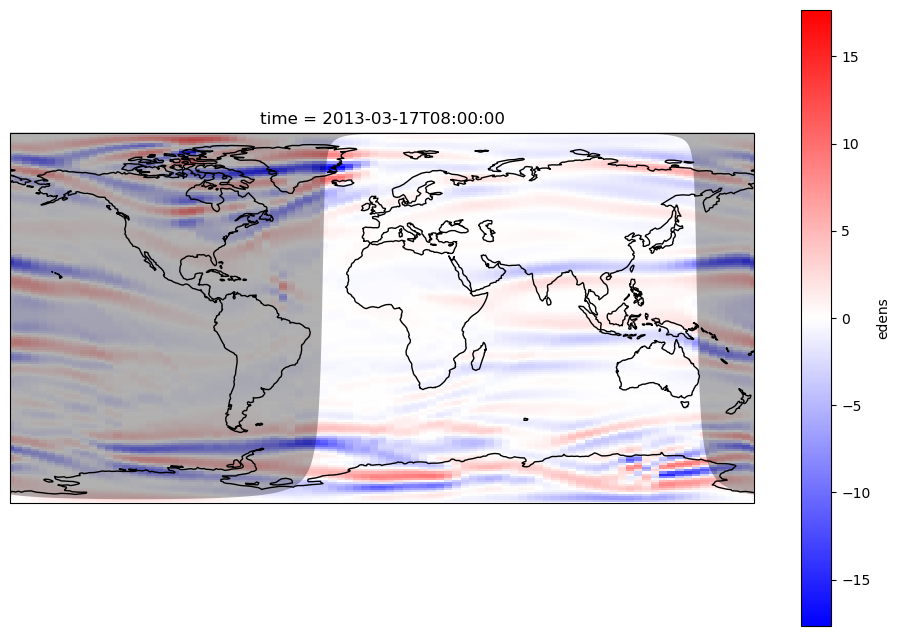

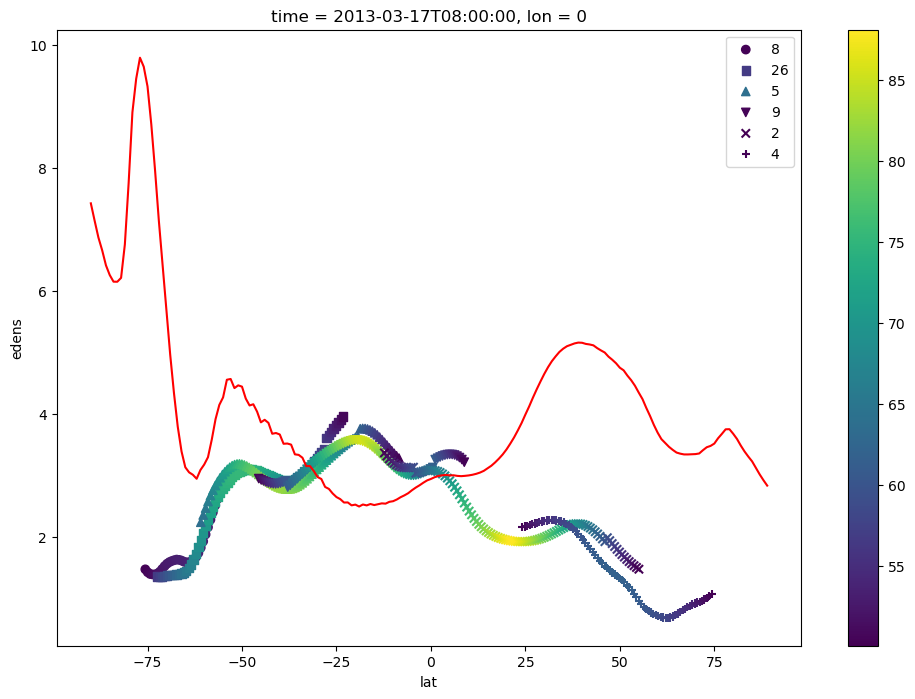

468 235
235


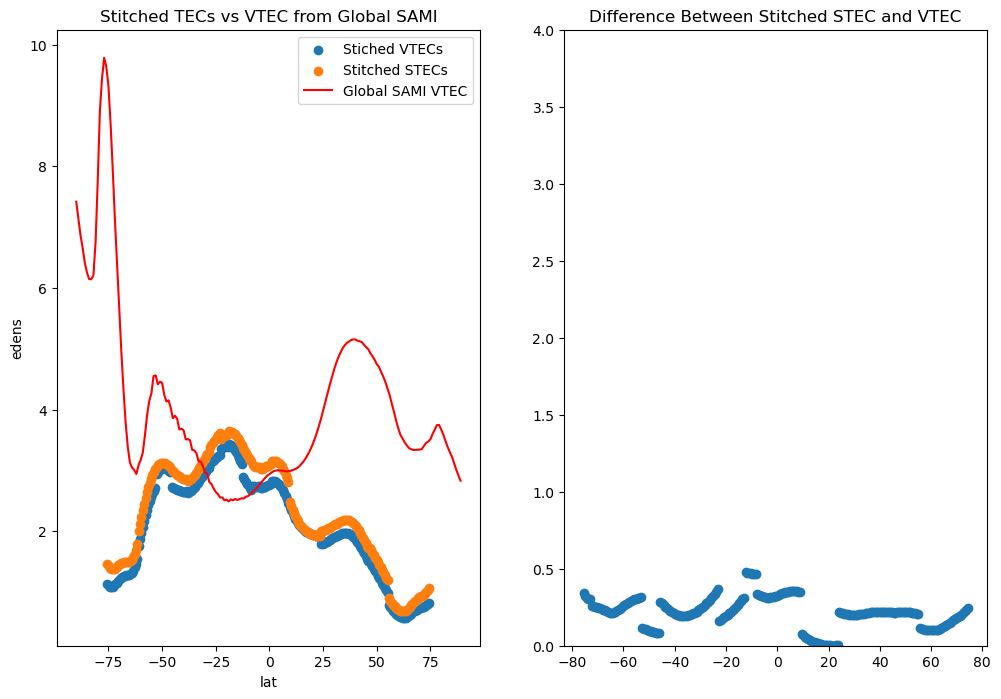

 83%|███████████████████████████████████▊       | 10/12 [02:42<00:32, 16.07s/it]

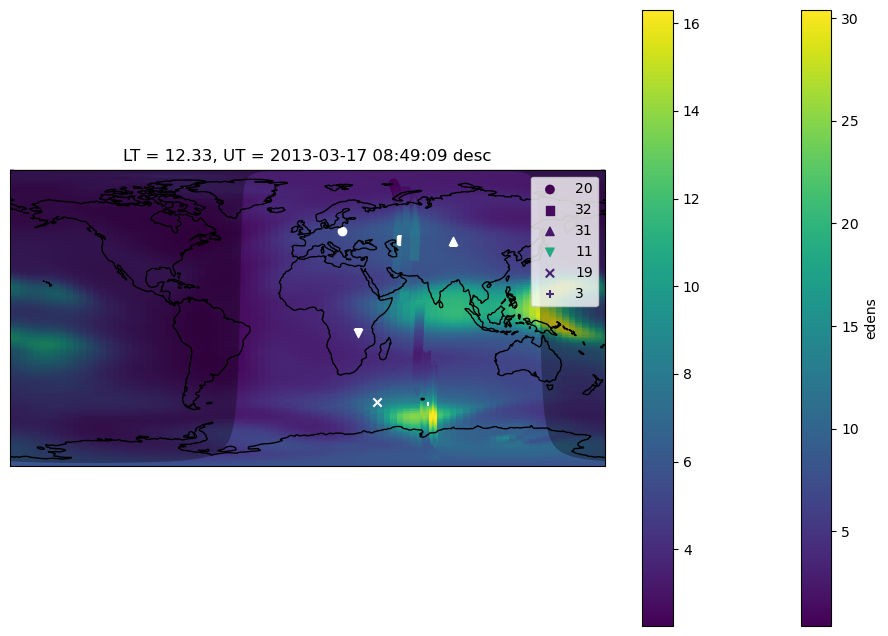

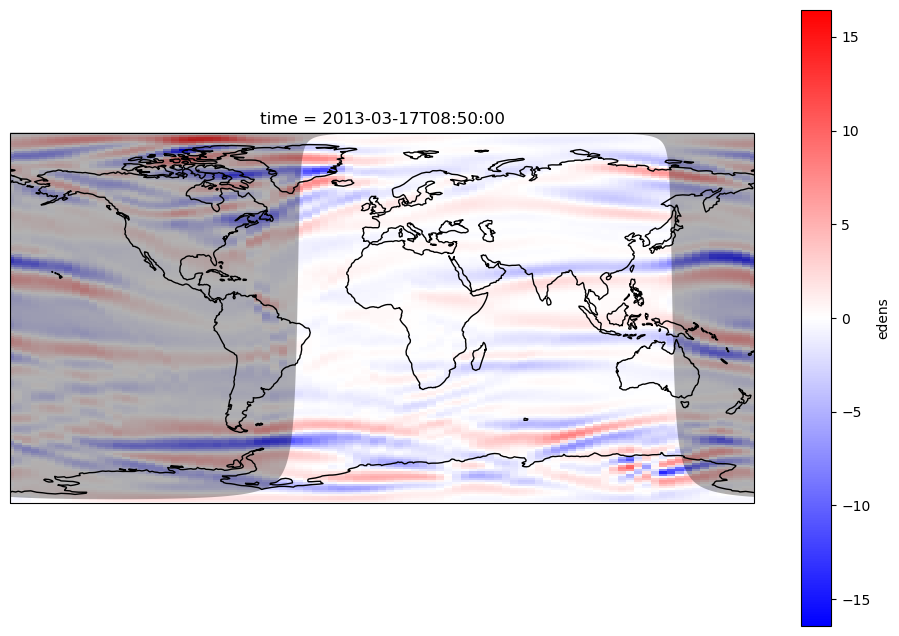

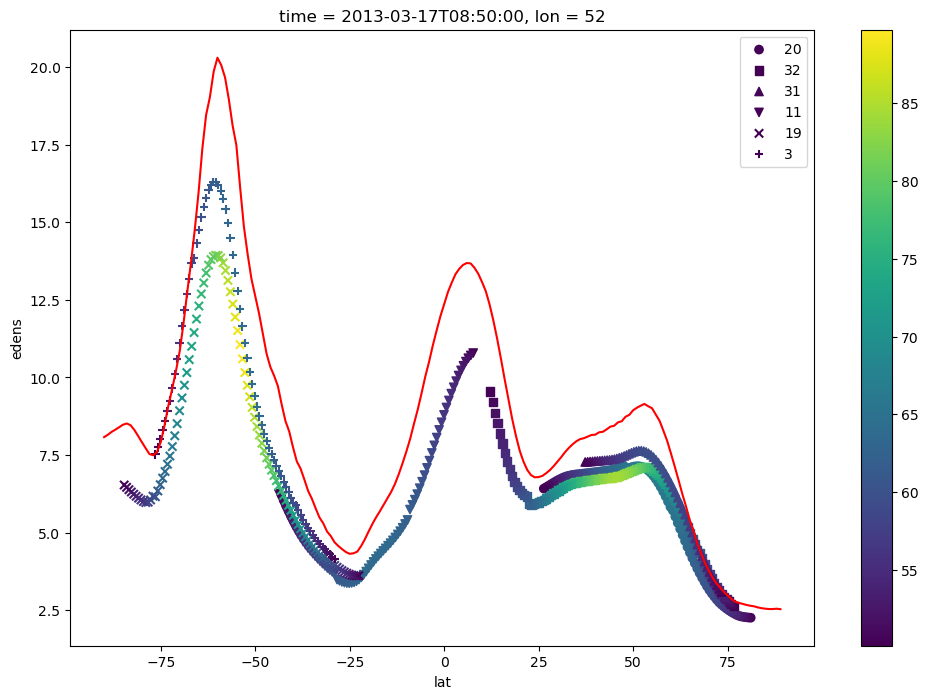

498 253
253


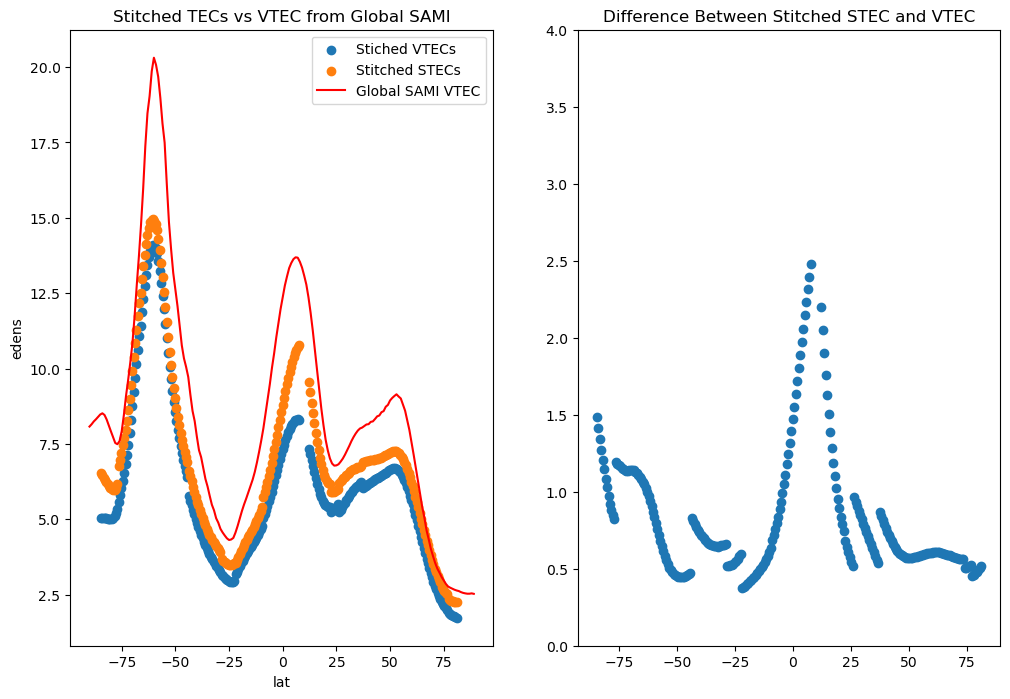

 92%|███████████████████████████████████████▍   | 11/12 [02:58<00:16, 16.04s/it]

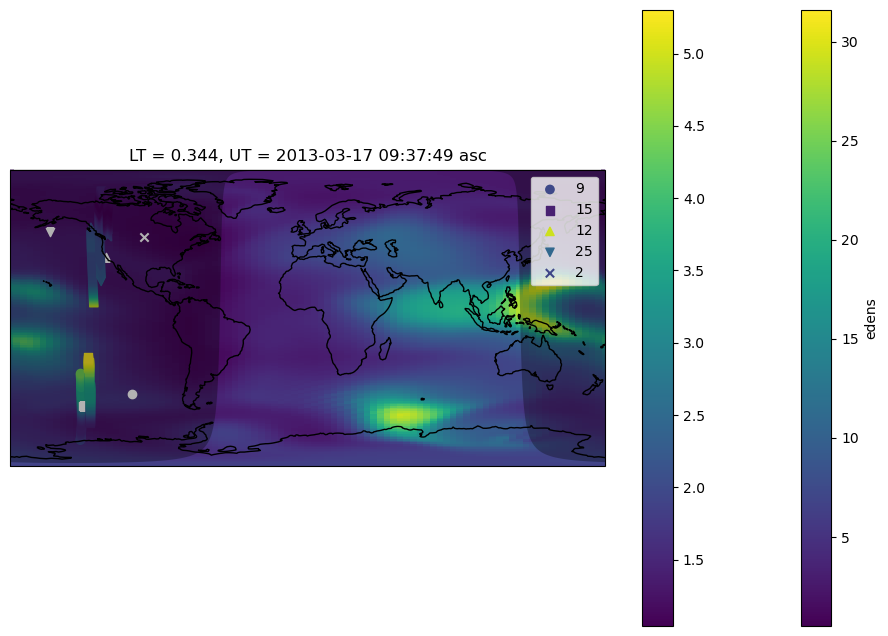

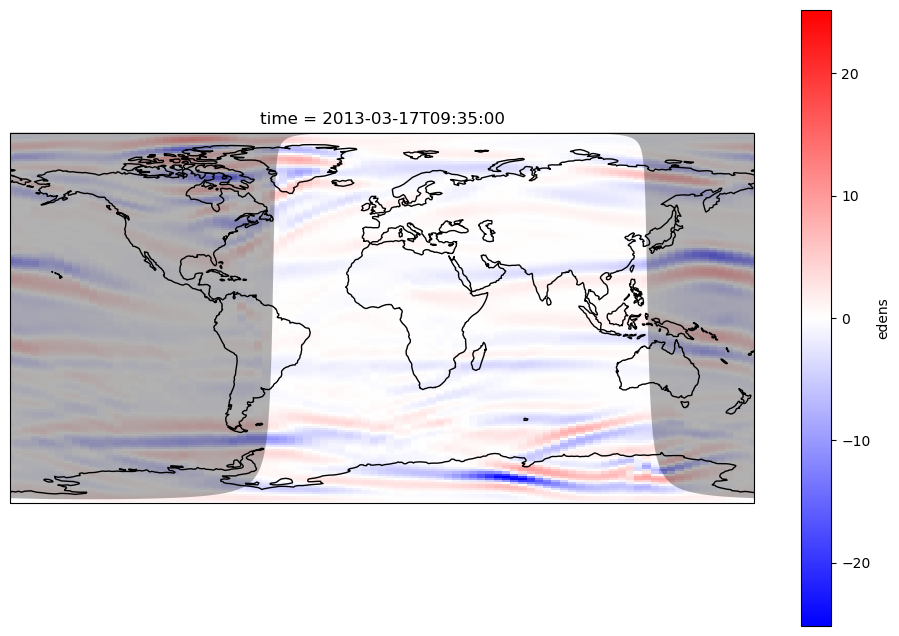

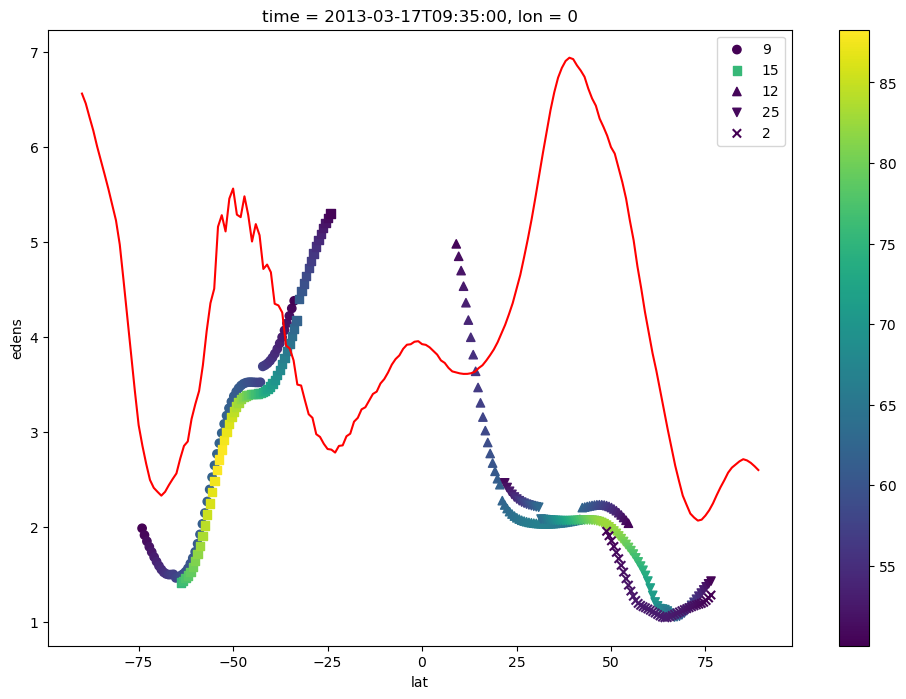

329 185
185


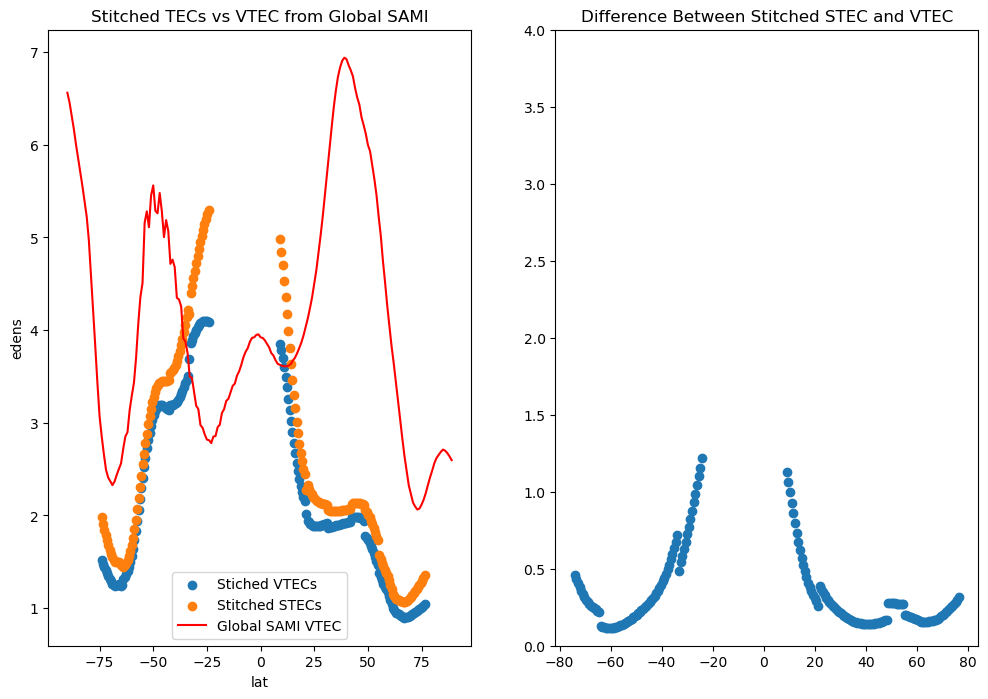

100%|███████████████████████████████████████████| 12/12 [03:14<00:00, 16.18s/it]


In [5]:
global_ds = xr.open_mfdataset('/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/temp/GLOBAL_SAMI_REGRID_new.nc',
                               engine='h5netcdf')

orbits = list(range(12))
path = '/home/pxv220016/scratch/multiorbit_data/' 

for orbit_num in tqdm(orbits):
    
    # reading data from .nc (contains interpolated edens values at 
    # the grid points that we provided in csv) and csv orbit files 
    file_path = path + 'orbit_' + str(orbit_num) + '_SAMI-REGRID.nc'
    los_ds = xr.open_dataset(file_path)
    
    csv_file = path + 'single_orbit_raw_' + str(orbit_num) + '.csv'
    df_grace = pd.read_csv(csv_file)

    # Finding the sami_time at the mid of the orbit
    dates = [pd.Timestamp(i) for i in df_grace.date]
    ref_date = dt.datetime(2013,1,1)
    sami_time = ref_date + sum([i - ref_date for i in dates], dt.timedelta())/len(df_grace.date)

    # Storing data in los_ds and reshaping it for easy integration
    los_ds['sat_pt'] = ('sat_pt'), df_grace.index
    los_ds['alt_lev'] = ('alt_lev'), list(range(50))
    n = len(df_grace)

    los_ds['lat'] = ('sat_pt','alt_lev'), los_ds.lat.values.reshape(n,50)
    los_ds['lon'] = ('sat_pt','alt_lev'), los_ds.lon.values.reshape(n,50)
    los_ds['alt'] = ('sat_pt','alt_lev'), los_ds.alt.values.reshape(n,50)
    los_ds['edens'] = ('sami_time', 'sat_pt','alt_lev'), los_ds.edens.values.reshape(596,n,50)

    # getting tecs through integration
    '''
    tecs = np.trapz(los_ds.sel(sami_time=sami_time, method='nearest').edens.values,
                   los_ds.alt.values,
                   axis=1) /1e7
    df_grace['tecs'] = tecs
    '''
    # calculating slant TEC by putting condition on upper height
    tecs = []
    
    for p in los_ds.sat_pt:
        
        h = 2400
        alt_all = los_ds.alt.sel(sat_pt=p).values
        eden_all = los_ds.sel(sami_time=sami_time, sat_pt = p, method='nearest').edens.values
        alt_h = []
        edens_h = []
        
        for i in range(len(alt_all)):
            if alt_all[i] <= h:
                # change 2400 to adjust the limit on height
                # 2400 is height till which gloabl_SAMI has obtained the data
                alt_h.append(alt_all[i])
                edens_h.append(eden_all[i])
    
        t = np.trapz(edens_h, alt_h)/1e7
        tecs.append(t)
    df_grace['tecs'] = tecs
    
    # obtaining VTEC from the global SAMI
    grace_est_tec = global_ds.sel(time=sami_time, 
                                  method='nearest').edens.where(global_ds.alt>500).dropna('alt').integrate('alt')/1e7
    
    # putting condition on the elevation angle
    elev_mask = df_grace.Elevation_Angle > 50 



    # ------PLOTTING---------

    # Plot will have VTEC in the background and STEC values at GRACE locations
    nature = ' asc'
    if df_grace.Latitude[0] > df_grace.Latitude[10]:
        nature = ' desc'
    
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    grace_est_tec.plot(x='lon')
    ax.coastlines()
    ax.add_feature(Nightshade(sami_time), alpha=0.3)
    
    n = int(len(df_grace.LT)/2)
    ax.set_title('LT = ' + str(df_grace.LT[n])[:5] + ', UT = ' + str(df_grace.date[n]) + nature)
    prn = df_grace.PRN[elev_mask].unique()
    shape = ['o', 's', '^', 'v', 'x', '+', '*', 'D']
    
    for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
        
        df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
        ecef_geodetic = il.reload(ecef_geodetic)
        lat, lon, _ = ecef_geodetic.ecef_to_lla(df_g1.GPS_Position_X[0],df_g1.GPS_Position_Y[0],df_g1.GPS_Position_Z[0])
        elev_mask1 = df_g1.Elevation_Angle > 50
        
        plt.scatter(lon, lat, marker = s, c='w')
        # each sub-intervals for different prn is offset by 5 longitudes to prevent overlapping
        plt.scatter(df_g1.Longitude[elev_mask1] + 5*i, df_g1.Latitude[elev_mask1], c=df_g1.tecs[elev_mask1], vmin = min(df_grace.tecs[elev_mask]), vmax = max(df_grace.tecs[elev_mask]), marker = s, transform=ccrs.PlateCarree(), label = p)     
    plt.legend()
    plt.colorbar();
    plt.show()



    
    # Plotting TIDs in global map
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    filt_filt(grace_est_tec).plot(x='lon', cmap='bwr')
    ax.coastlines()
    ax.add_feature(Nightshade(sami_time), alpha=0.3)

    
    
    
    # Plotting STEC and VTEC against Latitude
    plt.figure(figsize=(12,8))
    for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
        
        df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
        elev_mask1 = df_g1.Elevation_Angle > 50
        
        plt.scatter(df_g1.Latitude[elev_mask1], df_g1.tecs[elev_mask1], c=df_g1.Elevation_Angle[elev_mask1], vmin = min(df_grace.Elevation_Angle[elev_mask]), vmax=max(df_grace.Elevation_Angle[elev_mask]), marker =s, label = p)
    
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(color='red')
    plt.legend()
    plt.colorbar();
    plt.show()

    print(len(df_grace.tecs[elev_mask]), len(df_grace.Latitude[elev_mask].unique()))

    lats = df_grace.Latitude[elev_mask].unique()
    
    stec_t = []
    for l in lats:
        df_lat = (df_grace.iloc[np.where(df_grace.Latitude == l)].reset_index(drop = True))
        numer = 0
        denom = 0
        for st, el in zip(df_lat.tecs, df_lat.Elevation_Angle):
            if el > 50:
                numer += st*el
                denom += el    
        stec_t.append(numer/denom)

    print(len(stec_t))
    '''
    plt.figure(figsize=(12,8))
    plt.scatter(lats,stec, label='Stiched STECs')
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(color='red', label='Global SAMI VTEC')
    plt.legend()
    plt.show()
    '''

    '''
    # converting STEC to VTEC
    plt.figure(figsize=(12,8))
    for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
        
        df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
        elev_mask1 = df_g1.Elevation_Angle > 50

        vtec = [i*np.sin(np.radians(j)) for i,j in zip(df_g1.tecs[elev_mask1], df_g1.Elevation_Angle[elev_mask1])]
        plt.scatter(df_g1.Latitude[elev_mask1], vtec, c=df_g1.Elevation_Angle[elev_mask1], vmin = min(df_grace.Elevation_Angle[elev_mask]), vmax=max(df_grace.Elevation_Angle[elev_mask]), marker =s, label = p)
    
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(color='red')
    plt.legend()
    plt.colorbar();
    plt.show()
    '''
    
    vtec_t = []
    
    for l in lats:
        df_lat = (df_grace.iloc[np.where(df_grace.Latitude == l)].reset_index(drop = True))
        numer = 0
        denom = 0
        for st, el in zip(df_lat.tecs, df_lat.Elevation_Angle):
            if el > 50:
                numer += st*np.sin(np.radians(el))
                denom += 1 #np.sin(np.radians(el))   
        vtec_t.append(numer/denom)

    stitched_df = pd.DataFrame()
    stitched_df['lats'] = lats
    stitched_df['stec'] = stec_t
    stitched_df['vtec'] = vtec_t
    stitched_df_sort = stitched_df.sort_values(by=['lats'], ascending=True)
    
    # Smoothening of curves
    limits = 70
    latitudes = np.linspace(-limits, limits, 500, endpoint='True')
    b_spline_coeff_stec = make_interp_spline(stitched_df_sort.lats, stitched_df_sort.stec)
    b_spline_coeff_vtec = make_interp_spline(stitched_df_sort.lats, stitched_df_sort.vtec)
    stec_s = b_spline_coeff_stec(latitudes)
    vtec_s = b_spline_coeff_vtec(latitudes)
    stec_smooth = savgol_filter(stec_s, 50, 3)
    vtec_smooth = savgol_filter(vtec_s, 50, 3)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))    
    axs[0].scatter(lats,vtec_t, label='Stiched VTECs')
    axs[0].scatter(lats,stec_t, label='Stitched STECs')
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(ax=axs[0], color='red', label='Global SAMI VTEC')
    axs[0].legend()
    axs[0].set_title('Stitched TECs vs VTEC from Global SAMI')
    del_t = [i-j for i,j in zip(stec_t, vtec_t)]
    axs[1].set_title('Difference Between Stitched STEC and VTEC')
    axs[1].scatter(lats, del_t)
    axs[1].set_ylim(bottom = 0, top = 4)
    plt.show()
    

    stec_smooth_err = [100*(j-i)/i for i,j in zip(stec_s, stec_smooth)]
    vtec_smooth_err = [100*(j-i)/i for i,j in zip(vtec_s, vtec_smooth)]

    
    '''
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))    
    axs[0].plot(latitudes,vtec_smooth, label='Stiched VTECs')
    axs[0].plot(latitudes,stec_smooth, label='Stitched STECs')
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(ax=axs[0], color='red', label='Global SAMI VTEC')
    axs[0].legend()
    axs[0].set_xlim(left = -90, right = 90)
    axs[0].set_title('Smoothened Stitched TECs vs VTEC from Global SAMI')
    del_t = [i-j for i,j in zip(stec_smooth, vtec_smooth)]
    axs[1].set_title('Error Due to Smoothening of Stitched STEC and VTEC')
    axs[1].scatter(latitudes, vtec_smooth_err, label='% VTEC error')
    axs[1].scatter(latitudes, stec_smooth_err, label='% STEC error')
    axs[1].set_ylim(bottom = -10, top = 10)
    axs[1].set_xlim(left = -90, right = 90)
    plt.show()
    '''
    
    

In [4]:
los_ds

<xarray.Dataset> Size: 416MB
Dimensions:    (sat_pt: 1736, alt_lev: 50, sami_time: 596)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
  * sat_pt     (sat_pt) int64 14kB 0 1 2 3 4 5 ... 1730 1731 1732 1733 1734 1735
  * alt_lev    (alt_lev) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    lat        (sat_pt, alt_lev) float64 694kB -89.12 -89.02 ... 46.41 45.4
    lon        (sat_pt, alt_lev) float64 694kB 28.83 23.47 ... -145.3 -145.3
    alt        (sat_pt, alt_lev) float64 694kB 606.4 619.8 ... 2.019e+04
    edens      (sami_time, sat_pt, alt_lev) float64 414MB 7.609e+04 ... 0.0

In [ ]:
print(len(df_grace.tecs[elev_mask]), len(df_grace.Latitude[elev_mask].unique()))

    lats = df_grace.Latitude[elev_mask].unique()
    
    stec = []
    for l in lats:
        df_lat = (df_grace.iloc[np.where(df_grace.Latitude == l)].reset_index(drop = True))
        numer = 0
        denom = 0
        for st, el in zip(df_lat.tecs, df_lat.Elevation_Angle):
            if el > 50:
                numer += st*el
                denom += el    
        stec.append(numer/denom)
    
    plt.figure(figsize=(12,8))
    plt.scatter(lats,stec, label='Stiched STEC')
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(color='red', label='GlobalVTEC')
    plt.legend()
    plt.show()

In [21]:
import math

print(np.cos(np.radians(60)))

0.5000000000000001


In [ ]:
los_ds = xr.open_mfdataset('/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316/edens_SAMI-REGRID.nc')
                           #engine='h5netcdf')